# Lecture 7 - Quantile Regression

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Review what a quantile is.
- Compare the error functions of Ordinary Least-Squares (OLS) regression versus Quantile regression.
- Recognize the impacts of parametric and distributional assumptions in Quantile regression.
- Perform non-parametric Quantile regression.
- Perform parametric Quantile regression.

## Loading Libraries and Scripts

In [1]:
options(repr.matrix.max.rows = 6)
source("../scripts/support_functions.R")
library(tidyverse)
library(quantreg)
library(Lahman)
library(broom)
library(modelr)
library(glmbb)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    s

We will close our regression mindmap this block with an approach on **conditioned quantiles**: Quantile regression. Note we will check two approaches: parametric (for inference and prediction) and non-parametric (for prediction).

````{div} full-width
```{figure} ../img/reg-mindmap-7.png
:height: 600px
:name: reg-mindmap-7
Expanded regression modelling mind map (click on the image to zoom in).
```
````

## 1. The Quantiles

Let us set up an initial example to recap **what a quantile is**. Suppose we measure the height of $n = 1000$ randomly sampled UBC students. Here is the sample average in centimetres:

In [2]:
set.seed(123)
sample_heights <- draw_sample(1000)
sample_mean <- round(mean(sample_heights), 2)
sample_mean

[1] 175.11

```{exercise}
:label: lecture7-q1

**By only using that single sample average**, try to answer the following:

- How much do you know about the distribution of these `heights`?
- Is it a **symmetric distribution**?
- Is it a **heavy-tailed-distribution**?
- What is the **variance** of this distribution?
```

This is the reason why a boxplot is more meaningful than just jittered points.

Hence, let us get more information from the sample via `summary()` and `var()`.

In [3]:
summary(sample_heights)
paste("variance: ", round(var(sample_heights),2))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  155.3   170.6   175.1   175.1   179.7   197.7 

[1] "variance:  48.19"

```{exercise}
:label: lecture7-q2

What about now? Do we have a better idea about the distribution?

**A.** Yes, having different quantiles gives us a better idea about the distribution of heights.

**B.** Not, at all!
```

We can also make a quick histogram (with the sample mean as a vertical red line) or boxplot to confirm our previous statements.

In [4]:
options(repr.plot.height = 9, repr.plot.width = 20)

sample_heights <- as.data.frame(sample_heights)

hist_heights <- ggplot(sample_heights, aes(x = sample_heights)) +
  geom_histogram(color = "darkblue", fill = "lightblue", bins = 30) +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  ) +
  labs(x = "Height (cm)", y = "Count") +
  ggtitle("Histogram of Heights (n = 1000)") +
  geom_vline(xintercept = sample_mean, color = "red", linewidth = 1.5)

boxplot_heights <- ggplot(sample_heights, aes(y = sample_heights)) +
  geom_boxplot(color = "darkblue", fill = "lightblue") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank()
  ) +
  labs(y = "Height (cm)") +
  ggtitle("Boxplot of Heights (n = 1000)")

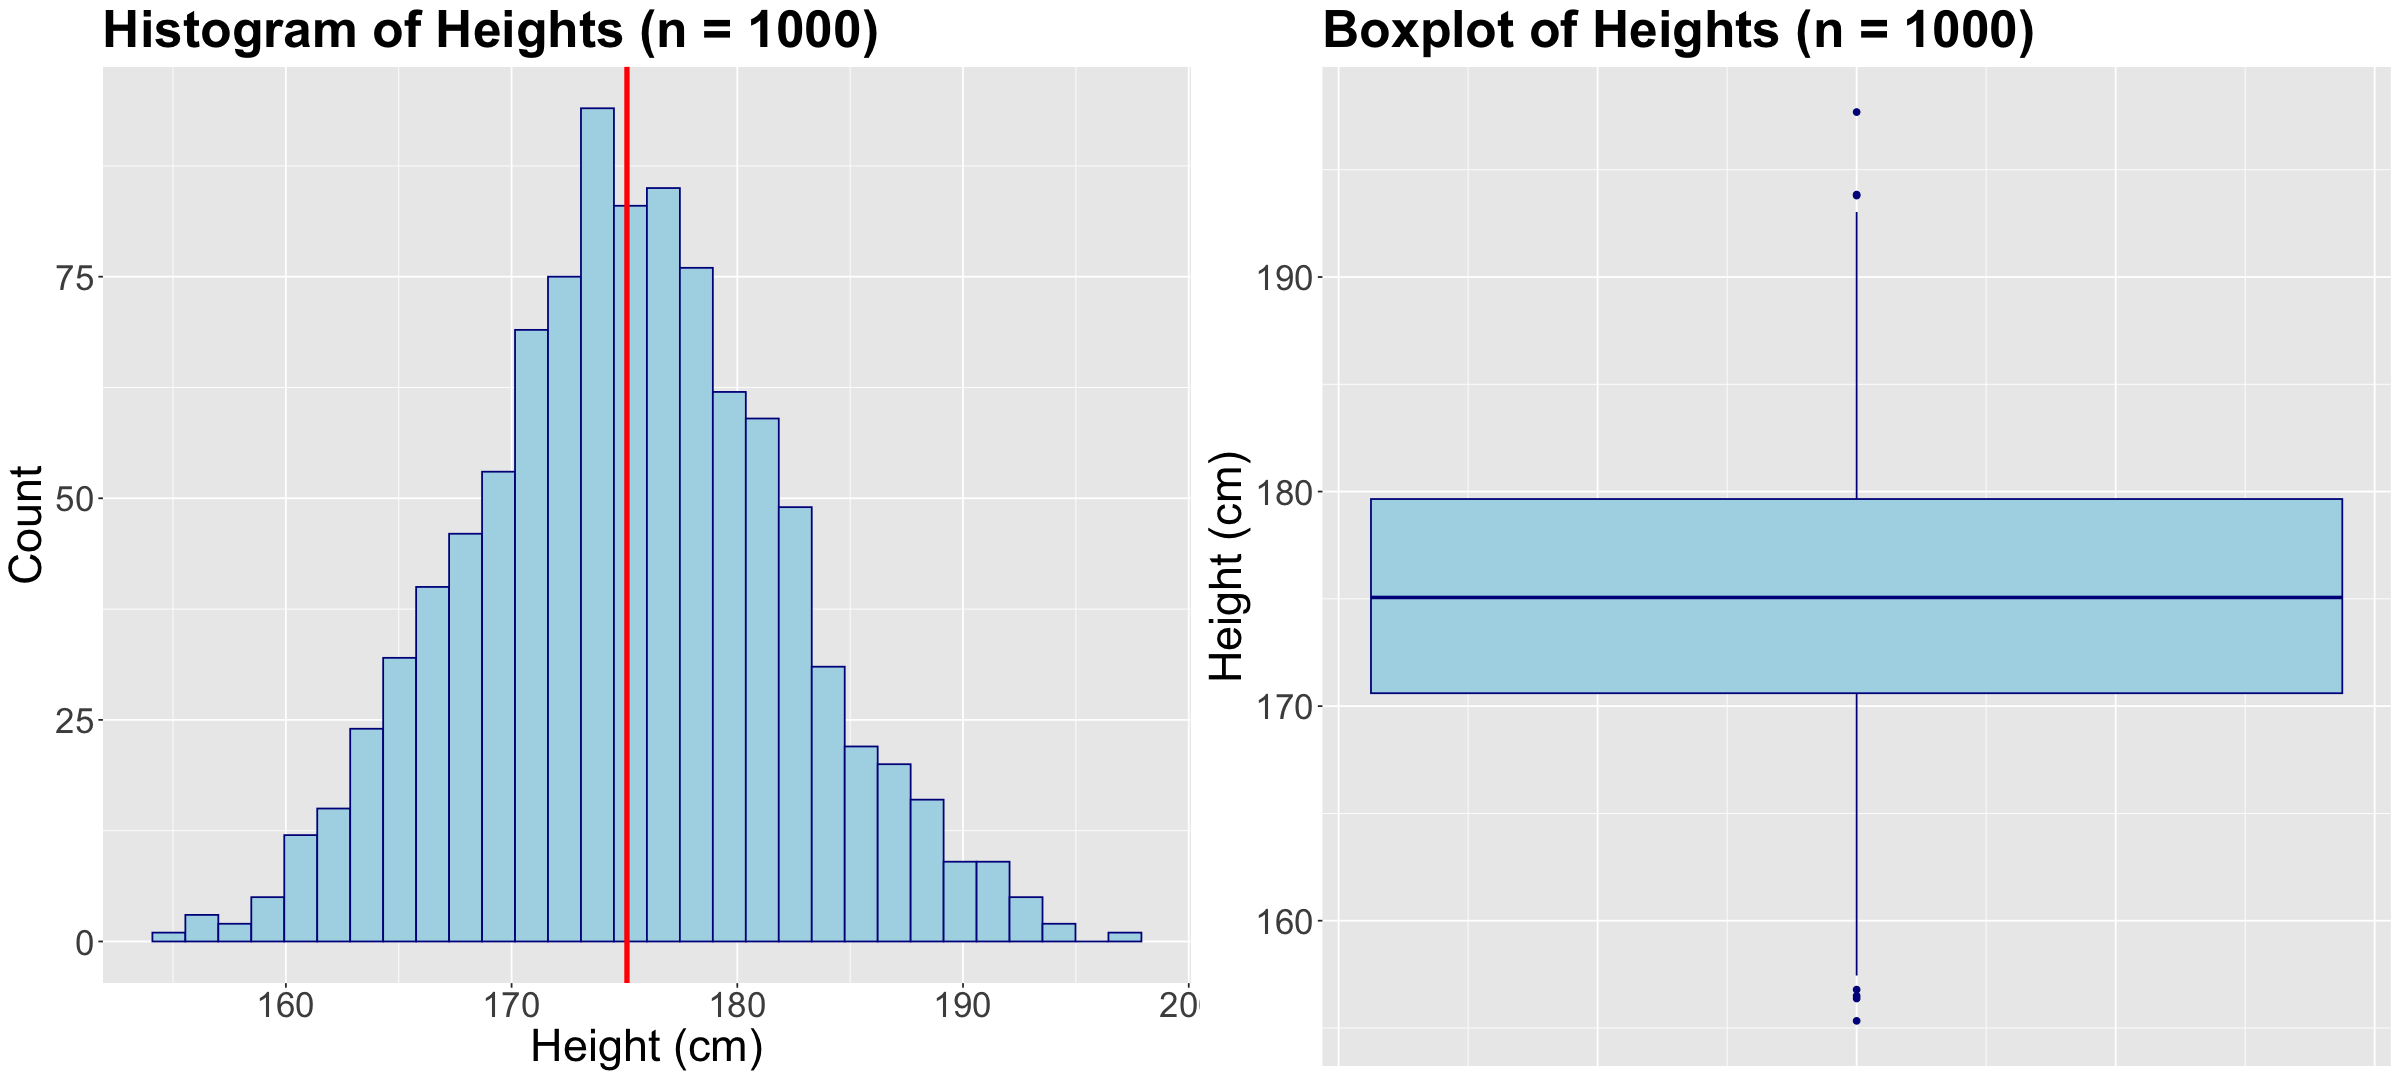

In [5]:
plot_grid(hist_heights, boxplot_heights)

### 1.1. Let us recall what a quantile is

Suppose we have a random variable $X\sim F_X(\cdot)$, i.e., $X$ has a cumulative distribution function (CDF) $F_X(\cdot)$. Then, the $\tau$-quantile ($0\leq \tau \leq 1$), is given by $Q(\tau)$ such that 

$$F_X[Q(\tau)]= P[X\leq Q(\tau)] = \tau.$$

In plain words, the quantile $Q(\tau)$ is that observed value of $X$ for which **$\tau \times 100\%$ of the population's data is below** (or **the area under the curve on the left-hand side of a given $x$**, if we check the horizontal axis on the probability density function).

As an example, we can check the case of the 0.75-quantile in the **Standard Normal distribution** using its probability density function (PDF).

In [6]:
q <- 0.75 # Quantile value between 0 and 1
sim_data <- tibble(x = seq(-3, 3, 0.01), f = dnorm(x))
quantile_plot <- sim_data %>%
  ggplot() +
  geom_line(aes(x, f)) +
  geom_segment(aes(x = x, y = 0, xend = x, yend = dnorm(x)),
    color = "red",
    linetype = "dotted",
    data = sim_data %>% filter(x <= qnorm(q))
  ) +
  geom_segment(aes(
    x = qnorm(q), y = 0, xend = qnorm(q),
    yend = dnorm(qnorm(q))
  ), color = "red") +
  scale_x_continuous(breaks = qnorm(q), labels = paste(
    "Q(", q, ") = ",
    round(qnorm(q), 4)
  )) +
  ggtitle(paste0("Quantile q = ", q)) +
  theme_bw() +
  annotate("text",
    x = -.25, y = .2, label = paste0(q * 100, "%"),
    size = 2 * sqrt(100 * q)
  ) +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 25),
    axis.title = element_text(size = 27)
  )

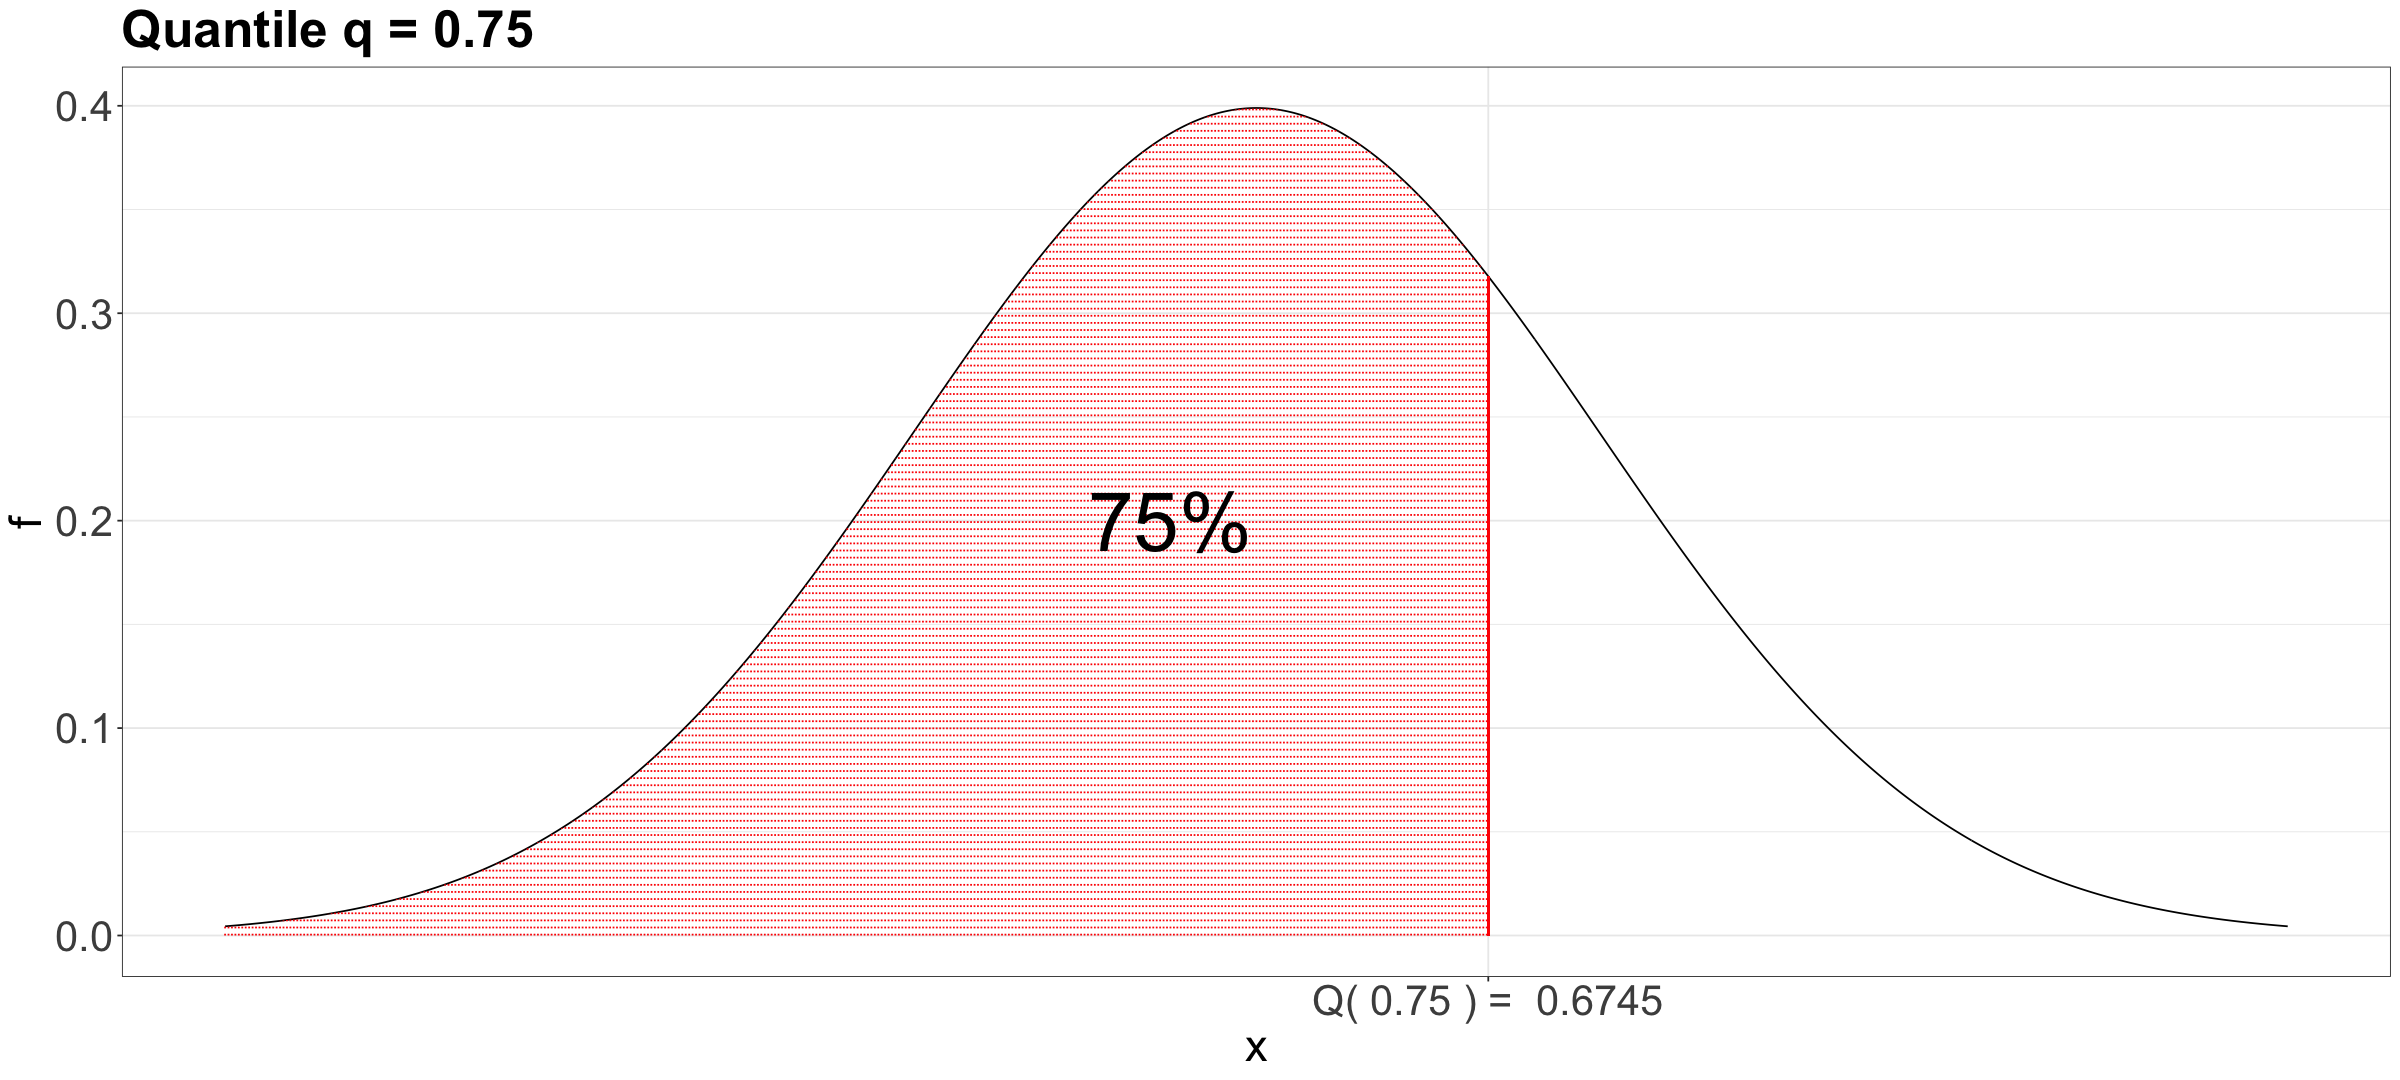

In [7]:
suppressWarnings(suppressMessages(print(quantile_plot)))

Moreover, we can also show it using the CDF where the cumulative probabilities are on the $y$-axis.

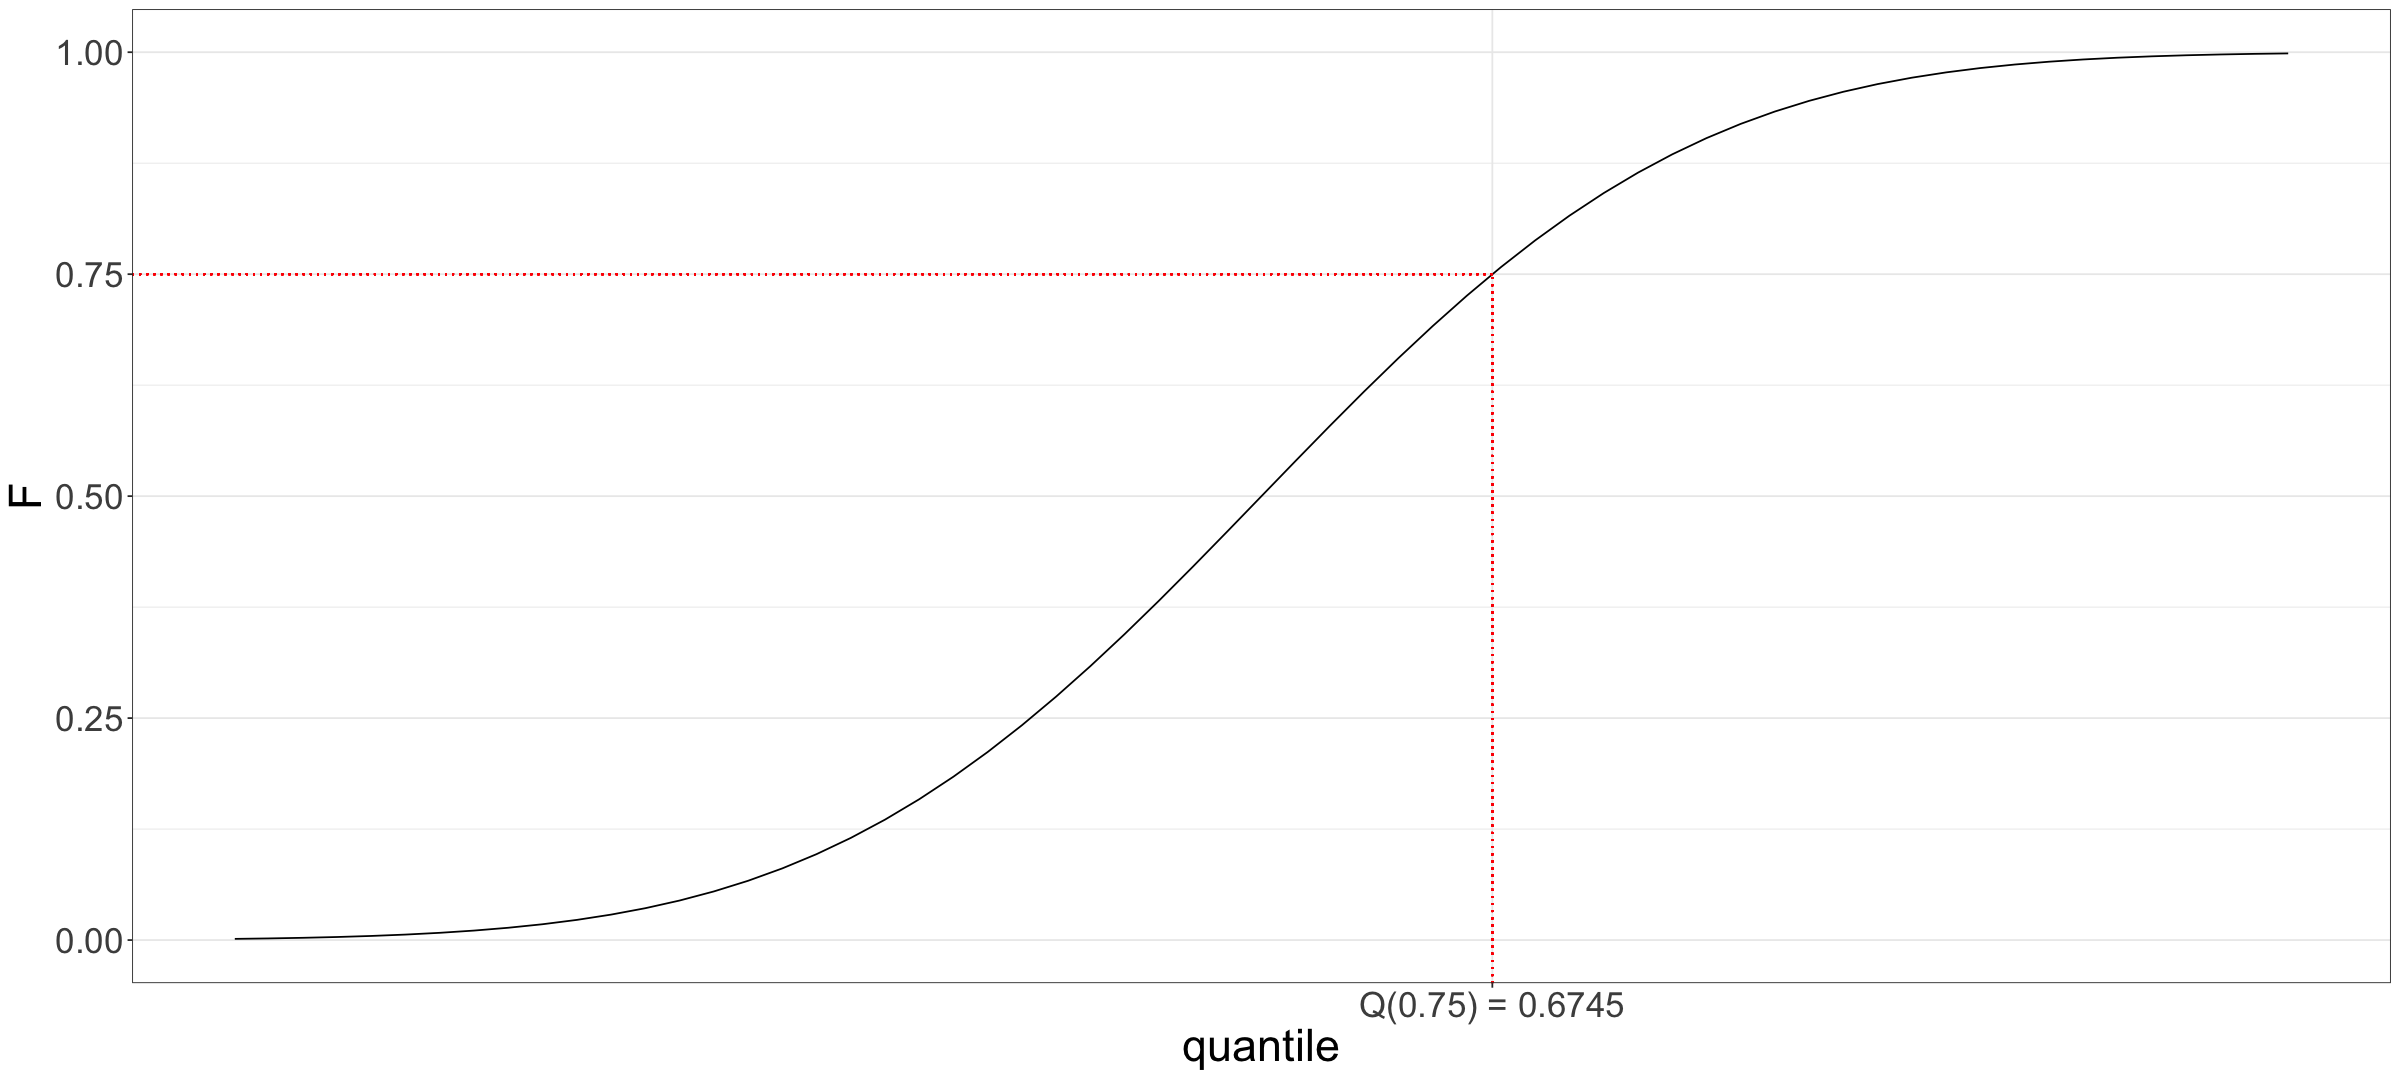

In [8]:
plot_example_quantile_cdf <- example_quantile_cdf(q = 0.75) +
  theme_bw() +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  )

suppressWarnings(suppressMessages(print(plot_example_quantile_cdf)))

### 1.2. Motivation for Quantile Regression

In the OLS regression model, we were focused on the conditional mean on the regressors:

$$
\mathbb{E}(Y_i \mid X_{i,j} = x_{i,j}) = \beta_0 + \beta_1 x_{i,1} + \ldots + \beta_k x_{i,k} \; \; \; \; \text{since} \; \; \; \; \mathbb{E}(\varepsilon_i) = 0.
$$

Moreover, we already discussed that (from the statistical point of view) regression models follow a stochastic relation.

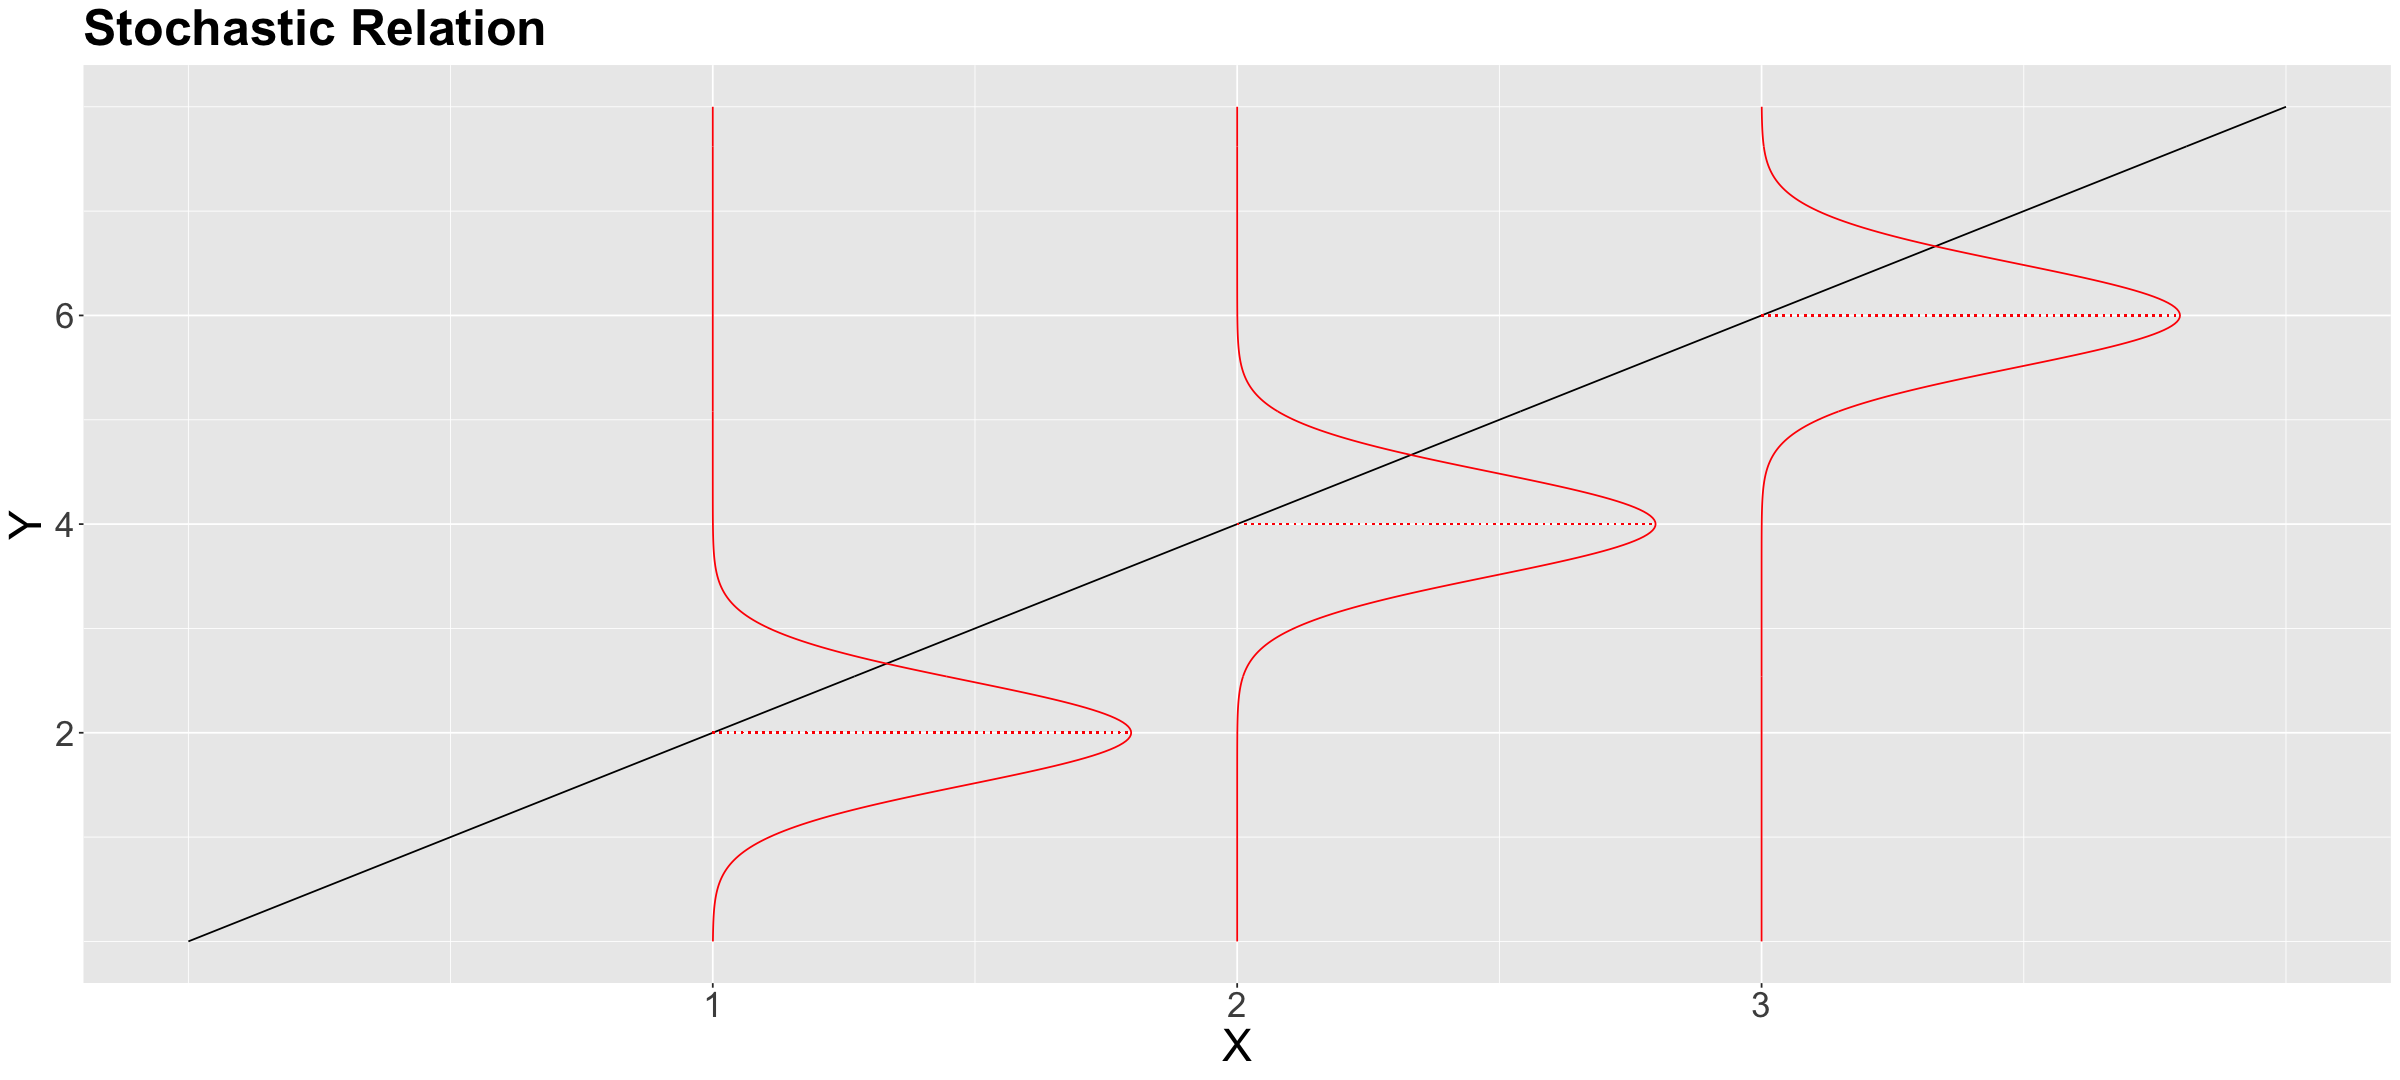

In [9]:
suppressWarnings(suppressMessages(print(example_stochastic_relation())))

Nonetheless, **is it possible to go beyond the conditioned mean?**

Given the stochastic nature of the relation between the response and explanatory variables, we have **a whole conditional distribution** of the response $Y_i$, given the $k$ explanatory variables $X_{i,j}$. 

```{important}
This whole conditional distribution **allows us to regress our response with more than just the mean, such as the median or any other quantiles!**

The below plot shows the stochastic nature of the conditional distribution for the $0.95$-quantile.
```

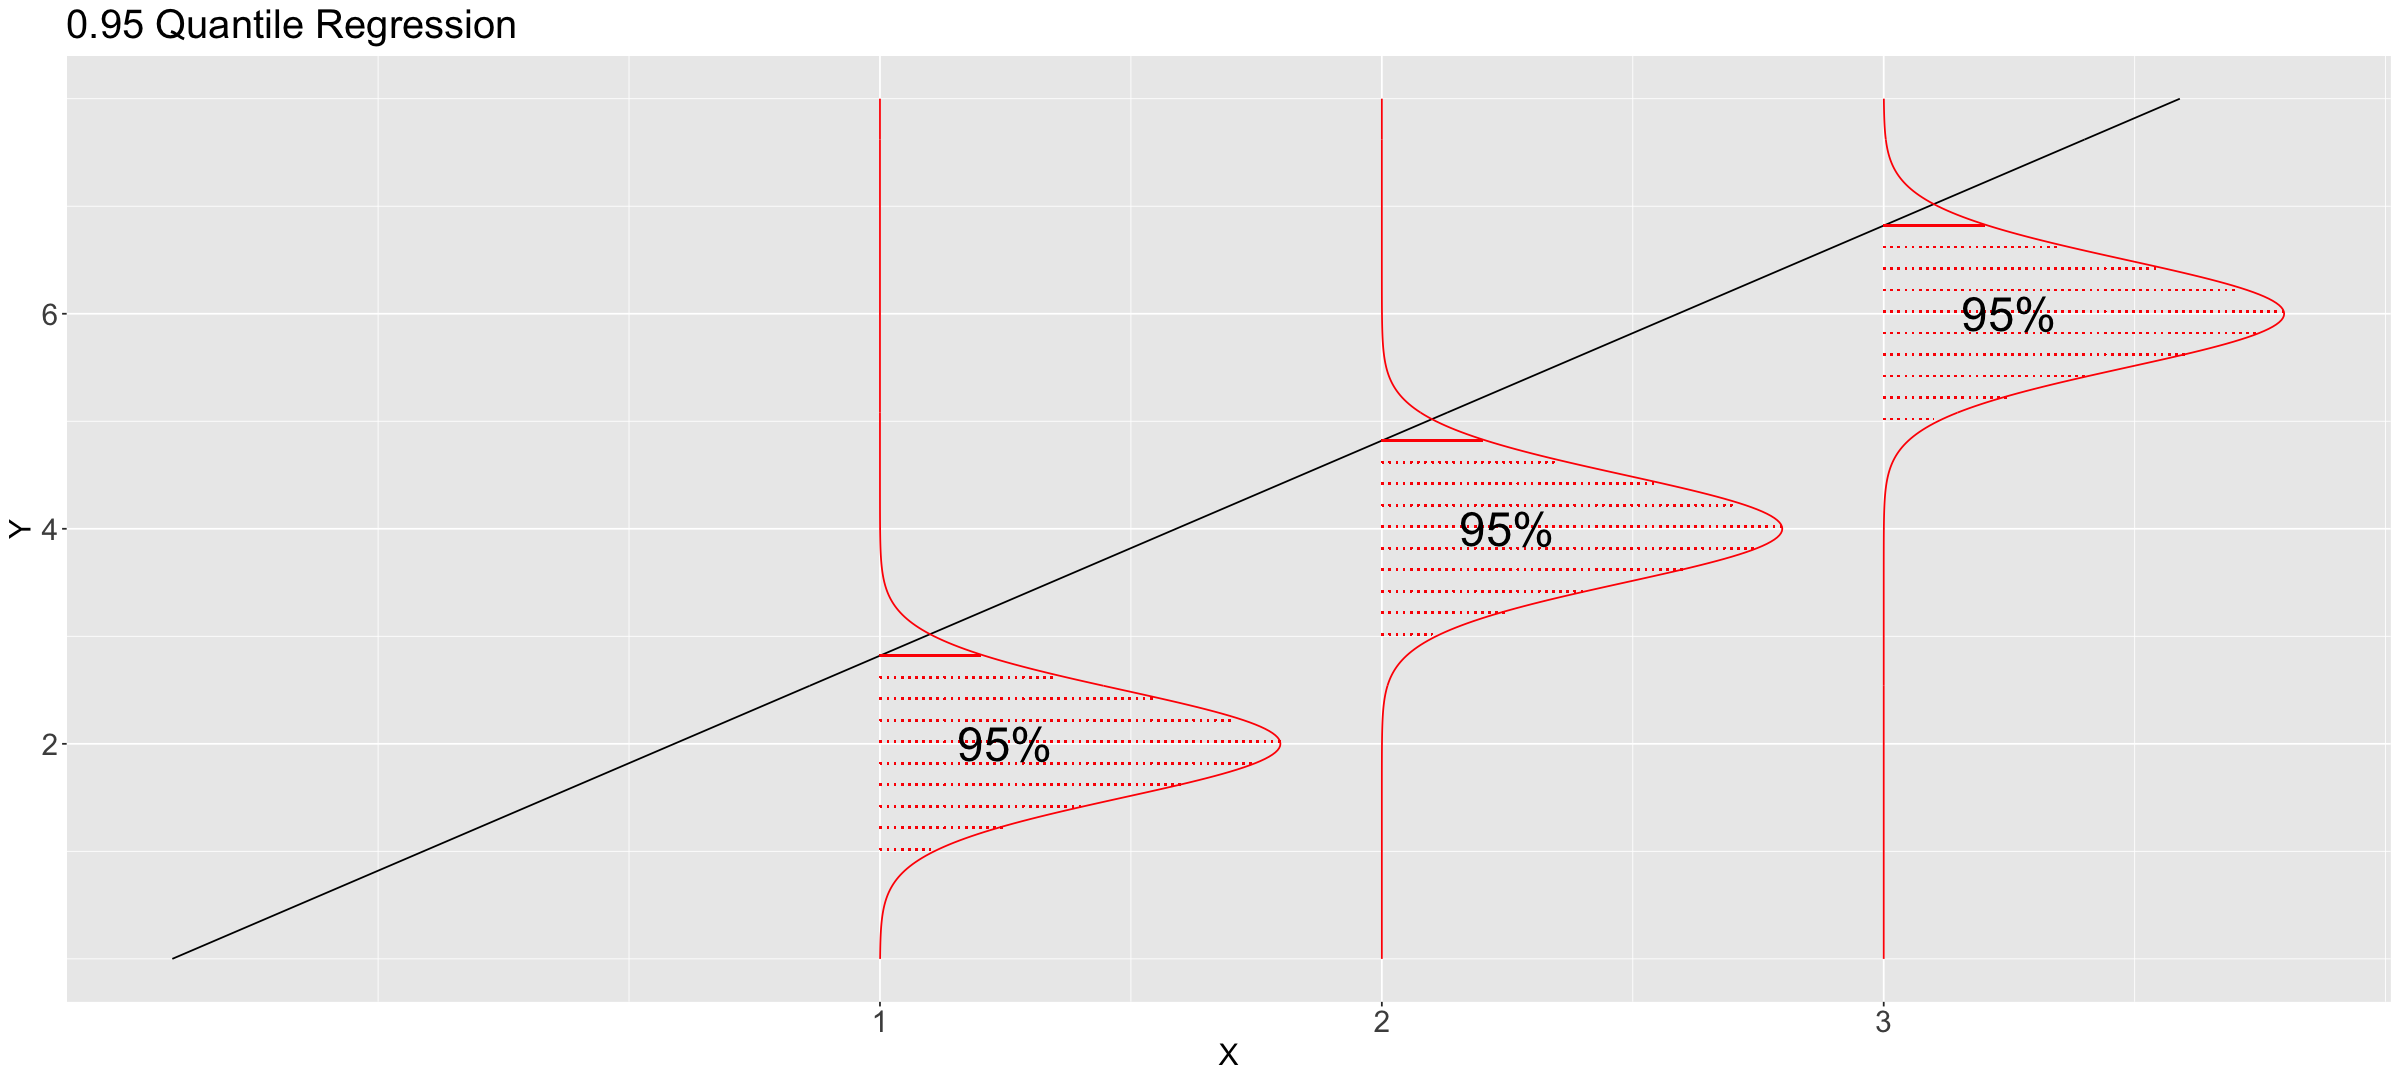

In [10]:
suppressWarnings(suppressMessages(print(example_quantile_regression())))

Having said all this, let us pave to this new regression framework called **Quantile regression**.

## 2. Applications of Quantile Regression

In many practical cases, we have **inferential questions** that are related to quantiles and not the mean.

We might want to see if, at different levels, the response is affected differently by the explanatory variables:

> *How do driver's years of experience affect buses' travel time when considering the 25% fastest travels, 50% fastest travels, and 90% fastest travels?*
>
> *How does the alcohol price affect the weekly consumption of light drinkers, moderate drinkers, and heavy drinkers at given cut-off values of alcohol consumption?*

Furthermore, we might also be interested in a **probabilistic prediction**:

> *During December in Vancouver, with a 95% chance, what is the maximum snowfall threshold?*

```{important}
This prediction **will not** be a confidence interval since we are talking about probabilities (i.e., chances). Therefore, we can use "probability" instead of "confidence." Moreover, we would obtain **prediction bands** (to be explained later on in this lecture).
```

Note we can translate these inquiries with $\tau$-quantiles ($\tau \in [0, 1]$) along with the regressor $X$ and response $Y$:

> *How do **driver's years of experience** ($X$) affect buses' **travel time** (Y) when considering the 25% fastest travels ($\tau = 0.25$), 50% fastest travels ($\tau = 0.5$), and 90% fastest travels ($\tau = 0.9$)?*

> *How does the **alcohol price** ($X$) affect the **weekly consumption** ($Y$) of light drinkers ($\tau = 0.25$), moderate drinkers ($\tau = 0.5$), and heavy drinkers ($\tau = 0.9$) in given cut-off values in weekly alcohol consumption?*

> *During **December** ($X$) in Vancouver, with a 95% ($\tau = 0.95$) chance, what is the **maximum snowfall** ($Y$) threshold?*

### 2.1. The Teams Dataset

For today's lecture, we will use the `Teams` dataset from the `Lahman` package. It has $n = 3015$ observations of 48 variables related to yearly statistics and standings for teams (**one row per team**) from different American baseball leagues.

```{note}
We can find the dataset's website[here](http://seanlahman.com/):

> The updated version of the database contains complete batting and pitching statistics from 1871 to 2022, plus fielding statistics, standings, team stats, managerial records, post-season data, and more.
```

We will use the following columns:

- `runs`: Runs scored, a **count**-type variable.
- `hits`: Hits by batters, a **count**-type variable.

In [11]:
teams <- Teams %>%
  select(runs = R, hits = H)
teams

runs hits
1    401  426 
2    302  323 
3    249  328 
⋮    ⋮    ⋮   
3013 707  1308
3014 775  1464
3015 603  1351

```{admonition} Main statistical inquiries
Let us suppose you are an American baseball enthusiast. You are interested in determining the following using this recorded data:

1. Previous research has shown you that a large number of runs is associated with a large number of hits. Having said that, **for those teams at the upper 75% threshold in runs**, is this association significant? If so, by how much?
2. **For any given team that scores 1000 hits in a future tournament**, how many runs can this team score with a 50% chance (centred around this future tournament's median runs)?
```

### 2.2. Exploratory Data Analysis

Let us create a scatterplot of `hits` (our regressor) versus `runs` (our response), **even though these variables are not continuous**.

```{attention}
The upcoming Quantile regression approaches are meant for continuous responses **in their most basic modelling frameworks**. Nevertheless, by looking at the below scatterplot, `runs` behaviour resembles a continuous variable given its clear scatteredness. This class of behaviour is case specific, and some other datasets whose response is a count would need an extra adjustment if it is much less scattered (an **optional material** in these notes).
```

In [12]:
teams_scatterplot <- ggplot(teams, aes(hits, runs)) +
  geom_point(alpha = 0.2, colour = "black") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  ) +
  xlab("Hits (Counts)") +
  ylab("Runs (Counts)") +
  ggtitle("Scatterplot of Hits versus Runs")

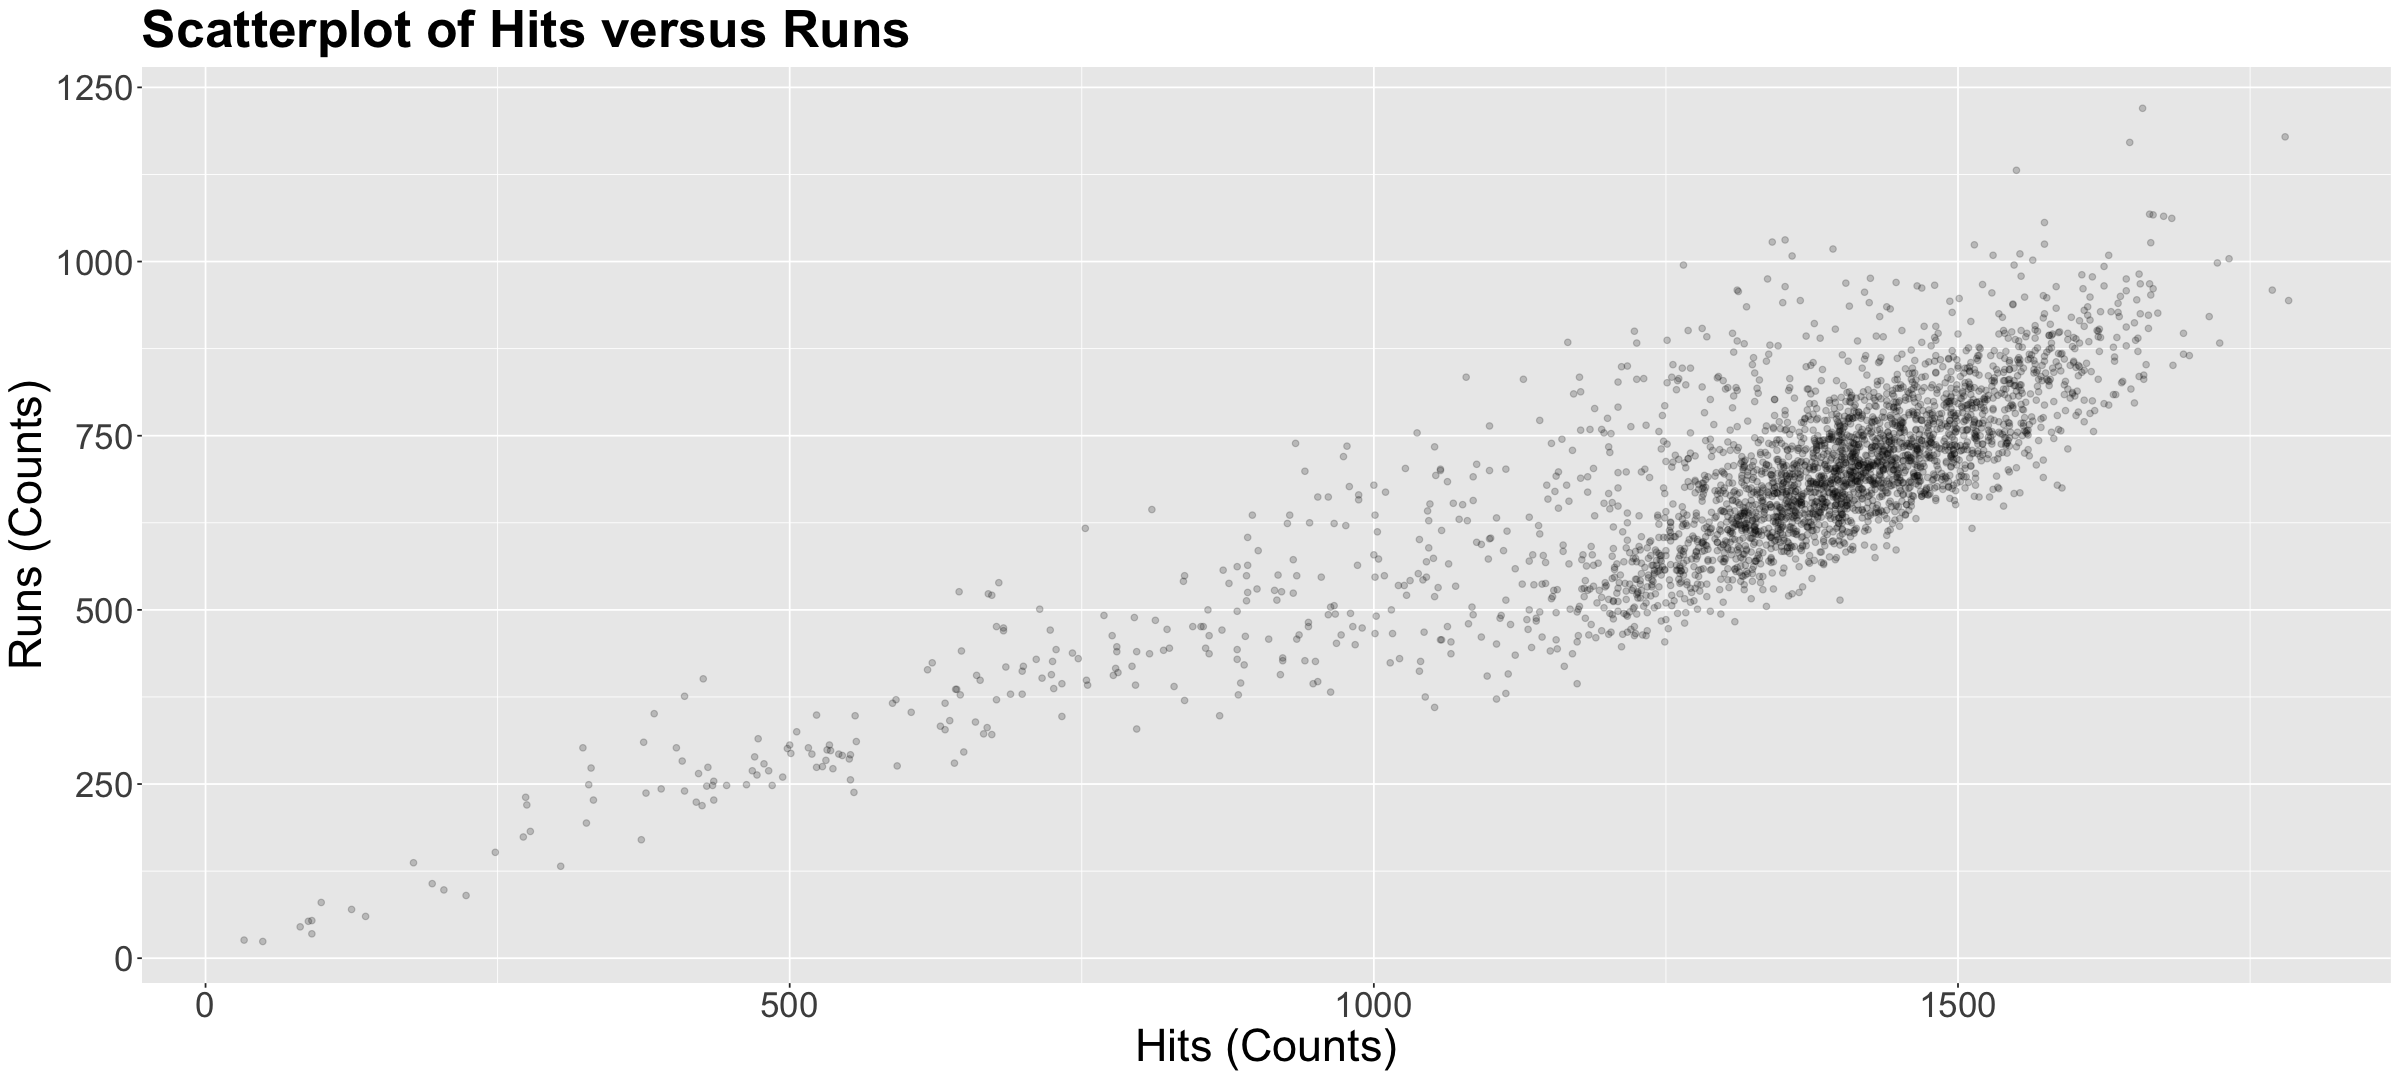

In [13]:
teams_scatterplot

This plot shows a clear positive relationship between `hits` and `runs`. Nevertheless, we need to go further and fit our corresponding model to address our inquiries.

## 3. Parametric Quantile Regression

We can address inquiries (1) and (2) via parametric Quantile regression. But before digging into this model, it is necessary to recall some fundamentals from OLS.

In OLS, we use a linear combination on the right-hand sice to explain the conditional mean

$$
\mathbb{E}(Y_i \mid X_{i,j} = x_{i,j}) = \beta_0 + \beta_1 x_{i,1} + \ldots + \beta_k x_{i,k};
$$

and then find $\hat{\beta}_0, \hat{\beta}_1, \dots, \hat{\beta}_k$ that **minimize the squared error (loss function) in our training set of size $n$**

$$
\sum_{i = 1}^n (y_i - \beta_0 - \beta_1 x_{i,1} - \ldots - \beta_k x_{i,k})^2.
$$

### 3.1. General Modelling Framework

On the other hand, **parametric Quantile regression** will condition the $\tau$-quantile ($\tau \in [0, 1]$) to $k$ regressors in a linear combination with an intercept $\beta_0(\tau)$ and $k$ regression coefficients:

```{math}
:label: conditioned-quantile
\begin{equation}
Q_i( \tau \mid X_{i,j} = x_{i,j}) = \beta_0(\tau) + \beta_1(\tau) x_{i,1} + \ldots + \beta_k(\tau) x_{i,k};
\end{equation}
```

and then find $\hat{\beta}_0(\tau), \hat{\beta}_1(\tau), \dots, \hat{\beta}_k(\tau)$ that **minimize the following error function (loss function)**

```{math}
:label: fidelity-function
\begin{equation}
\sum_{i} e_i[\tau - I(e_i < 0)] = \sum_{i: e_i \geq 0} \tau|e_i|+\sum_{i: e_i < 0}(1-\tau)|e_i|
\end{equation}
```

```{important}
Unlike OLS, where there is a single model fitting, **any Quantile regression approach** (either parametric or non-parametric) would require fitting **as many models as quantiles we are interested in**! (check the variable nature of $\tau$ on the left-hand side of the equation).

$\beta_j(\tau)$ means that the regression term depends on the quantile $\tau$, which is the desired quantile. In other words, for each quantile, we (might) have a different regression function on the right-hand side of our modelling equation.
```

In the previous loss function {eq}`fidelity-function`, we have the indicator variable

```{math}
\begin{equation*}
I(e_i < 0) =
\begin{cases}
1 \; \; \; \; \mbox{if $e_i$ < 0},\\
0 \; \; \; \; 	\mbox{otherwise;}
\end{cases}
\end{equation*}
```

where the residual is

$$e_i = y_i - \overbrace{\big[\hat{\beta_0}(\tau) + \hat{\beta_1}(\tau) x_{i,1} + \ldots + \hat{\beta_k}(\tau) x_{i,k}\big]}^{\hat{y}_i}$$ 
$$e_i = y_i - \hat{y}_i$$

This error function is called **fidelity**.

To understand how the fidelity function works, using the `teams` dataset, let us plot the three estimated parametric Quantile regression lines for quantiles $\tau = 0.25, 0.5, 0.75$ (**how to plot these lines along with obtaining their `R` model objects will be discussed later on in this lecture**). Our response $Y$ is `runs`, whereas our regressor $X$ is `hits`. 

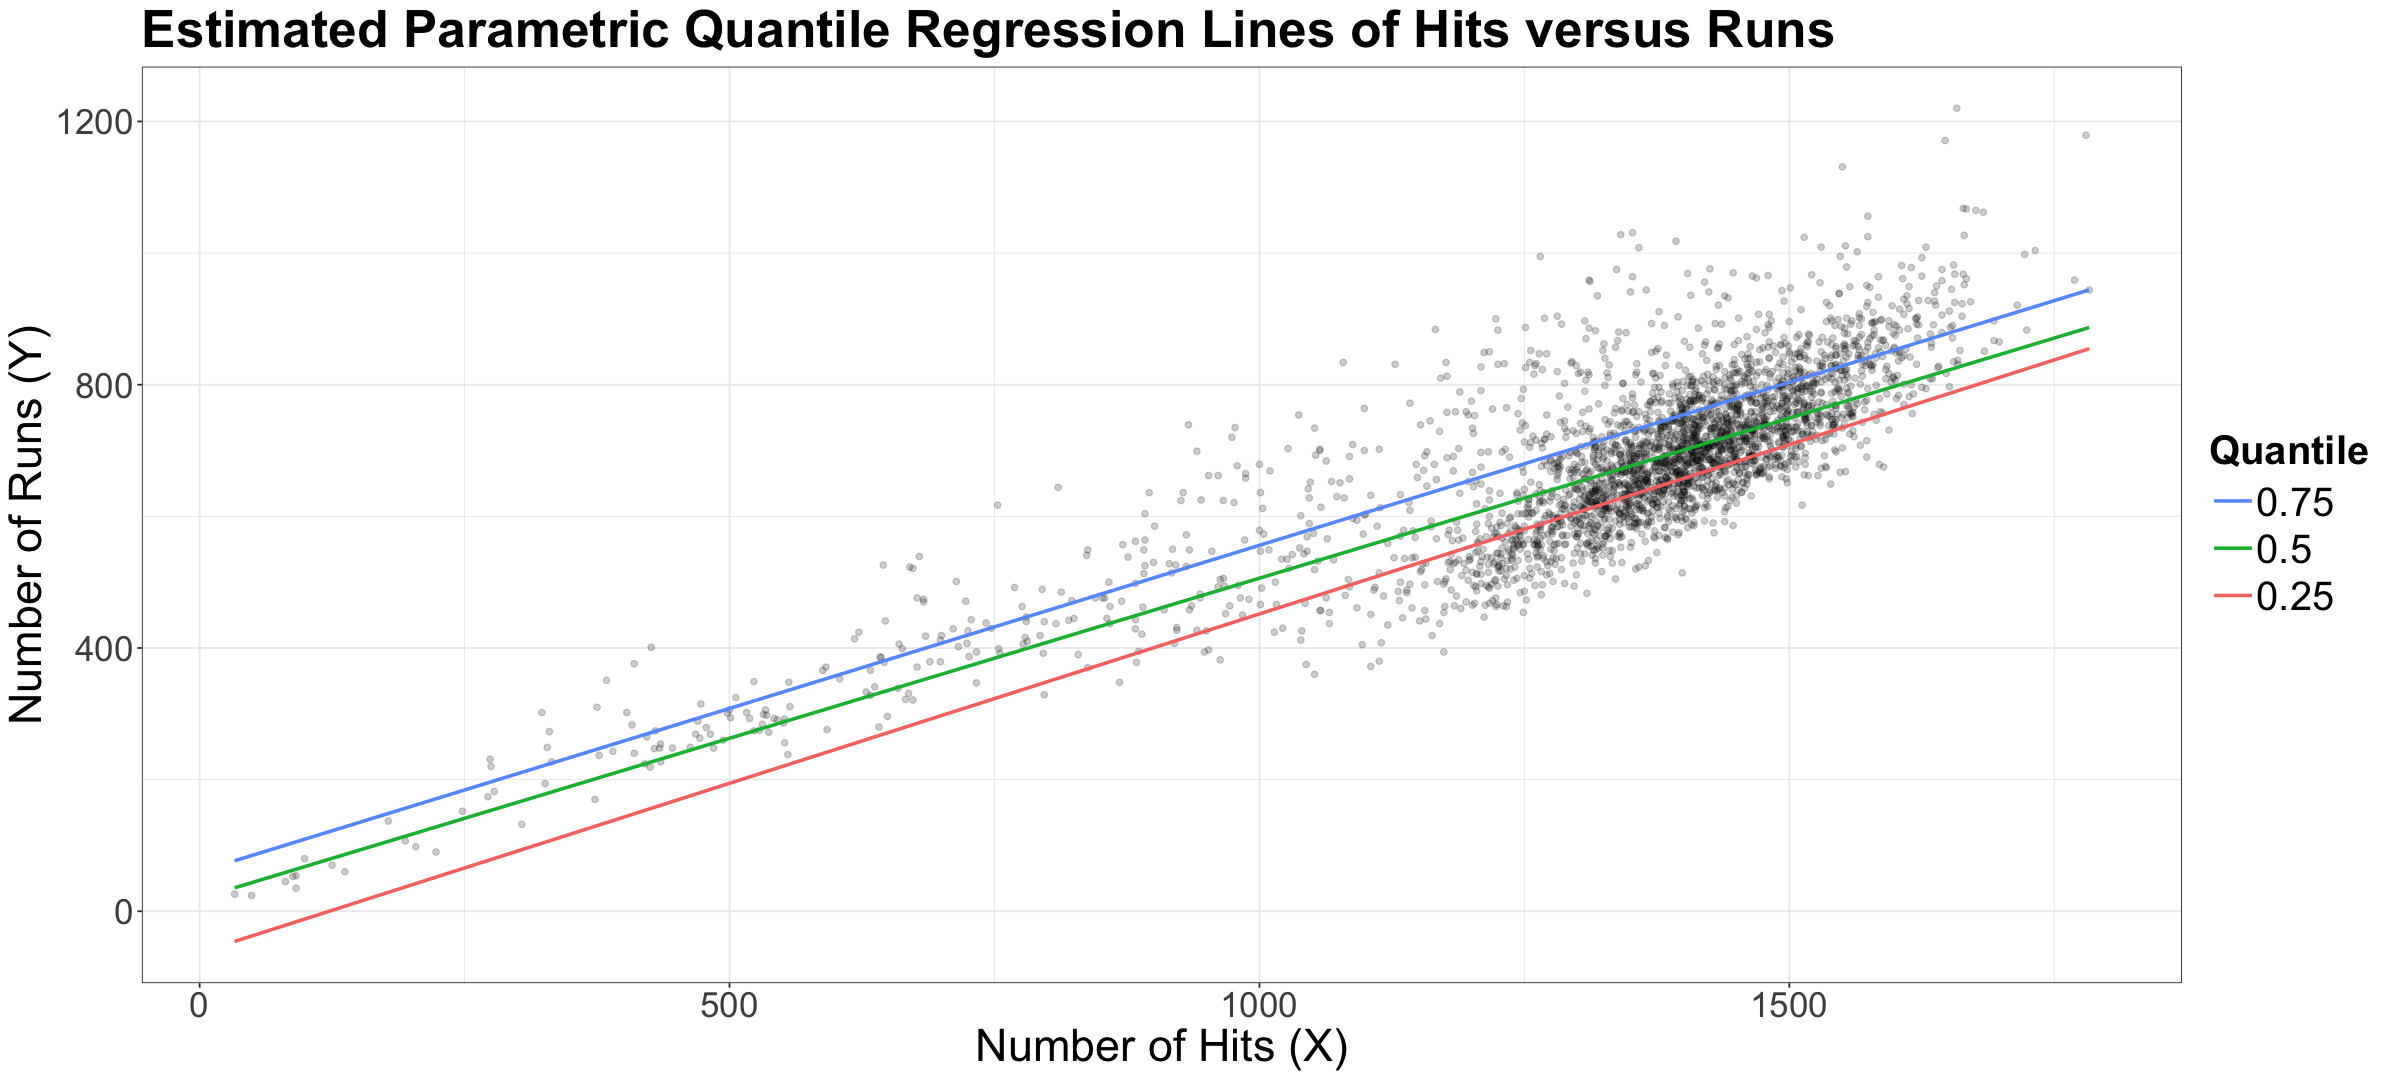

In [14]:
ggplot(teams, aes(hits, runs)) +
  geom_point(alpha = 0.2, colour = "black") +
  geom_quantile(
    quantiles = c(0.25, 0.5, 0.75), aes(colour = as.factor(after_stat(quantile))),
    formula = y ~ x, linewidth = 1
  ) +
  theme_bw() +
  labs(
    x = "Number of Hits (X)",
    y = "Number of Runs (Y)"
  ) +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 24, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 24, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  guides(colour = guide_legend(title = "Quantile", reverse = TRUE)) +
  ggtitle("Estimated Parametric Quantile Regression Lines of Hits versus Runs")

The above plot shows that the $0.75$-Quantile regression has the largest estimate for the intercept, followed by the $0.5$-Quantile regression. Finally, $0.25$-Quantile regression shows the smallest estimate.

```{important}
A fundamental characteristic of a $\tau$-Quantile regression (**either parametric or non-parametric**) is that we will practically have the $\tau \times 100\%$ of our observed responses below our estimated regression line via $\hat{\beta}_0(\tau), \hat{\beta}_1(\tau), \dots, \hat{\beta}_k(\tau)$.
```

Once we have seen this pattern on the estimated regression lines for quantiles $\tau = 0.25, 0.5, 0.75$, let us check how the fidelity function {eq}`fidelity-function` behaves so we can understand it more. 

**In general for $k$ regressors, assume we have the same set of regressor values $x_{i,1}, \dots, x_{k,1}$ in the panels below ($\tau = 0.25, 0.5, 0.75$). Moreover, we will have the corresponding set of estimates $\hat{\beta}_0(\tau), \hat{\beta}_1(\tau), \dots, \hat{\beta}_k(\tau)$ by quantile $\tau = 0.25, 0.5, 0.75$.** 

Having said all this, note we have the values of the corresponding fidelity function {eq}`fidelity-function` on the $y$-axis, whereas we have the corresponding values for the residual 

$$e_i = y_i - \overbrace{\big[\hat{\beta_0}(\tau) + \hat{\beta_1}(\tau) x_{i,1} + \ldots + \hat{\beta_k}(\tau) x_{i,k}\big]}^{\hat{y}_i}$$ 
$$e_i = y_i - \hat{y}_i$$

on the $x$-axis.

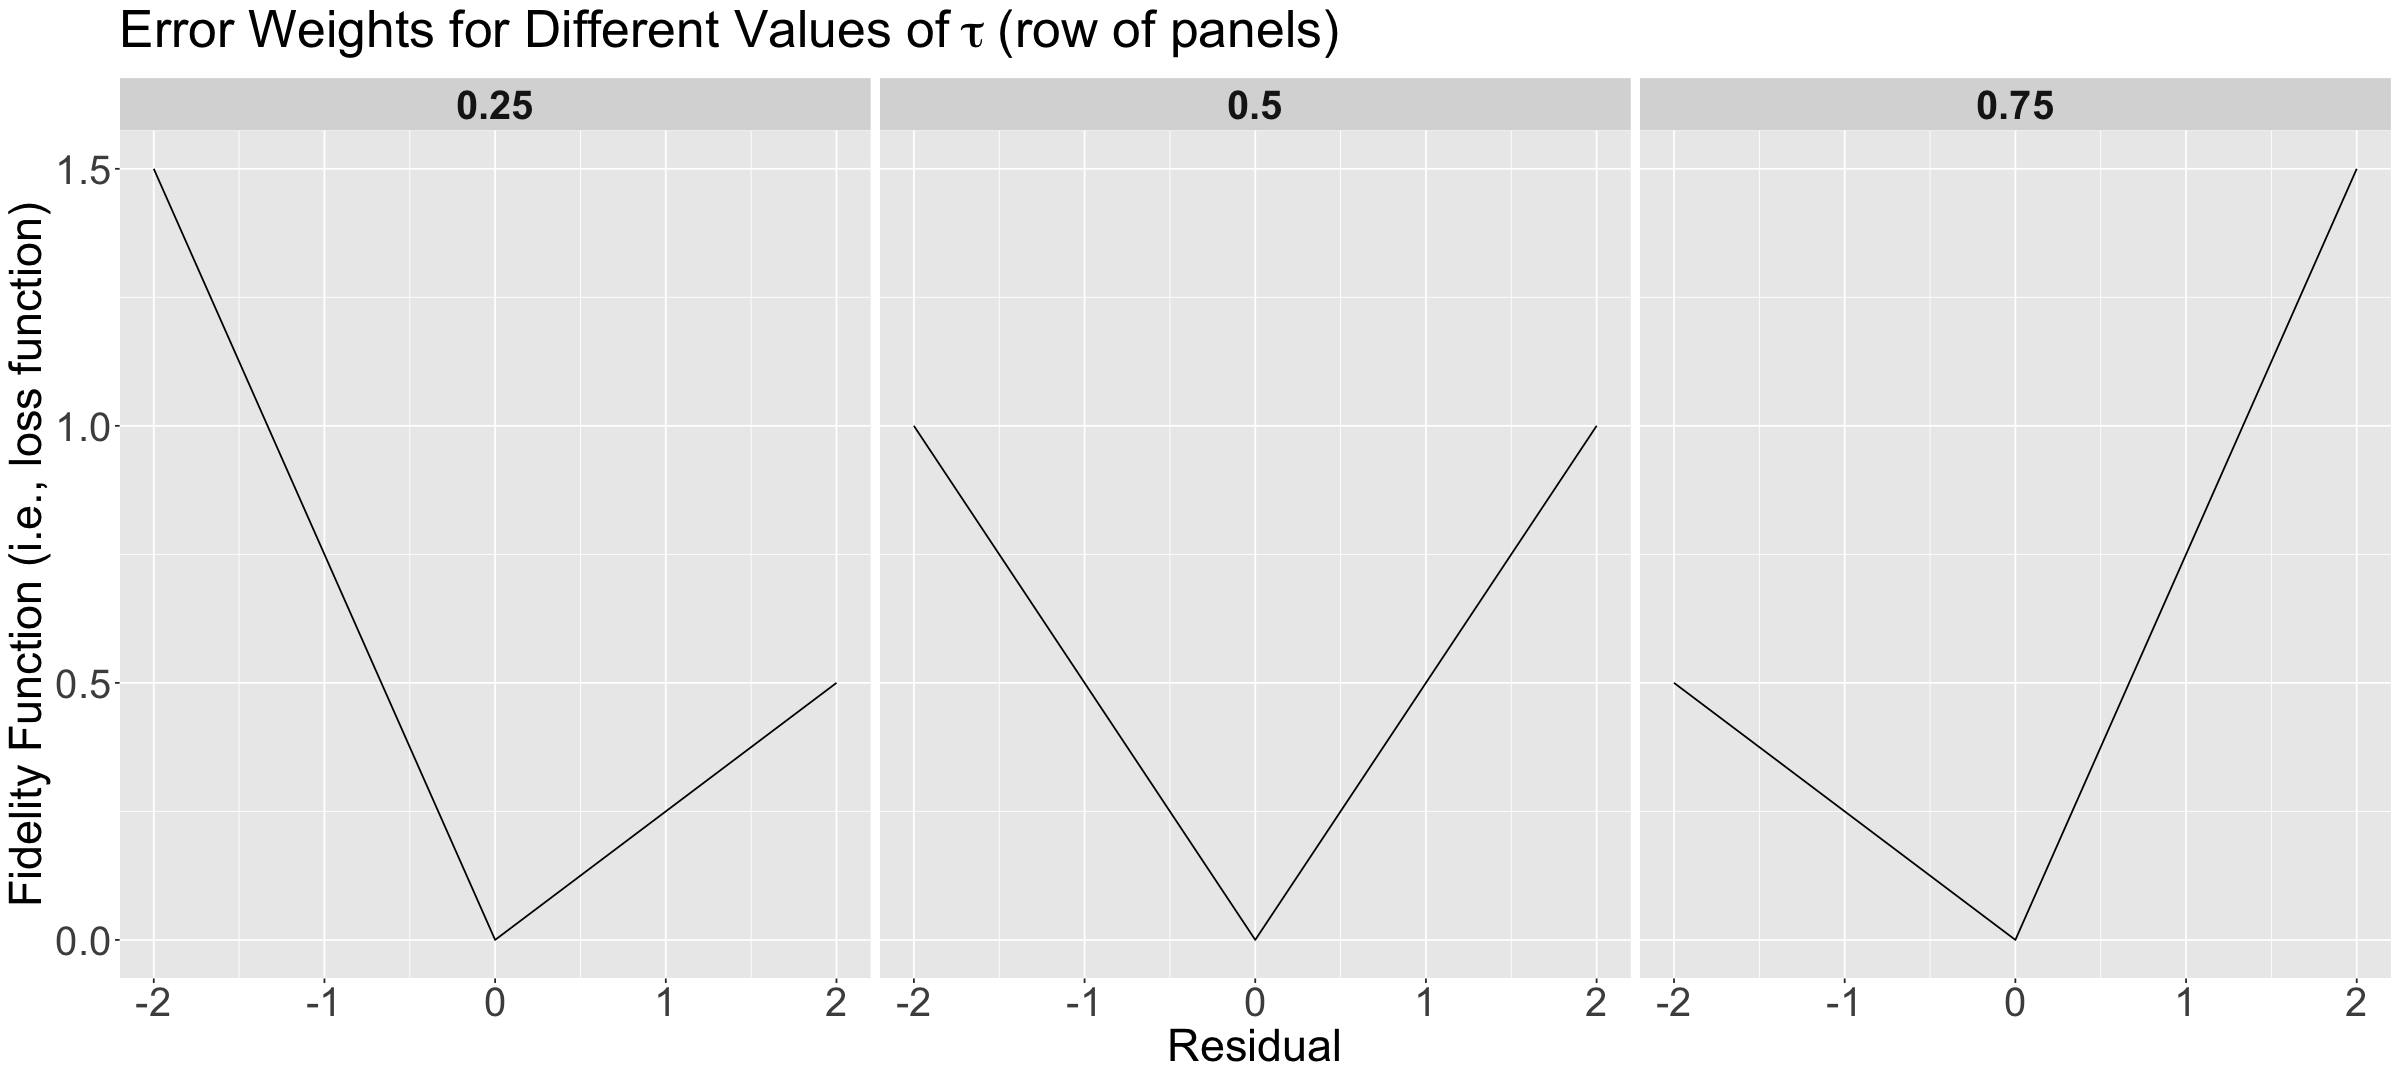

In [15]:
error_data <- tibble(
  residual = seq(-2, 2, 0.1),
  "0.25" = (0.25 - (residual < 0)) * residual,
  "0.5" = (0.5 - (residual < 0)) * residual,
  "0.75" = (0.75 - (residual < 0)) * residual
) %>%
  gather(key = tau, value = error_function, "0.25", "0.5", "0.75")

error_data %>%
  ggplot() +
  facet_grid(cols = vars(tau)) +
  geom_line(aes(residual, error_function)) +
  ggtitle(bquote("Error Weights for Different Values of" ~ tau ~ "(row of panels)")) +
  theme(
    plot.title = element_text(size = 31), 
    strip.text = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 24), 
    axis.title = element_text(size = 27)
  ) +
  labs(x = "Residual", y = "Fidelity Function (i.e., loss function)")

We will go panel by panel from left to right:

$\tau = 0.25$

Recall the **residual** is

$$e_i = y_i - \overbrace{\big[\hat{\beta_0}(\tau) + \hat{\beta_1}(\tau) x_{i,1} + \ldots + \hat{\beta_k}(\tau) x_{i,k}\big]}^{\hat{y}_i}.$$

Note that for low values of $\tau$, **we consider overpredicting** 

$$e_i = y_i - \hat{y}_i < 0$$ 

**WORSE than underpredicting**

$$e_i = y_i - \hat{y}_i > 0.$$

Note how steeper is the penalty (on the $y$-axis) when we overpredict (the negative part on the $x$-axis). So, we prefer to err on the side of underpredicting (the positive part on the $x$-axis).

```{attention} 
Since we prefer to err on the side of underpredicting in this scenario, to decrease the error function value even more we need to provide **smaller** estimated values for $\hat{\beta_0}(\tau), \hat{\beta_1}(\tau), \dots, \hat{\beta_k}(\tau)$. In a 2-$d$ scenario ($Y$ versus a single $X$ with $\hat{\beta_0}(\tau)$ and $\hat{\beta_1}(\tau)$ as regression parameters), this will **pull down** the estimated regression line in a plot.
```

$\tau = 0.5$

For $\tau = 0.5$, we care equally about underpredict and overpredict. This corresponds to the median value. 

$\tau = 0.75$

Recall the **residual** is

$$e_i = y_i - \overbrace{\big[\hat{\beta_0}(\tau) + \hat{\beta_1}(\tau) x_{i,1} + \ldots + \hat{\beta_k}(\tau) x_{i,k}\big]}^{\hat{y}_i}$$

For high values of $\tau$, it is the opposite. **We consider underpredicting**

$$e_i = y_i - \hat{y}_i > 0$$ 

**WORSE than overpredicting**

$$e_i = y_i - \hat{y}_i < 0.$$ 

Note how steeper is the penalty (on the $y$-axis) when we underpredict (the positive part on the $x$-axis). So, we prefer to err on the side of overpredicting (the negative part on the $x$-axis).

```{attention} 
Since we prefer to err on the side of overpredicting in this scenario, to decrease the error function on the $y$-axis even more we need to provide **larger** estimated values for $\hat{\beta_0}(\tau), \hat{\beta_1}(\tau), \dots, \hat{\beta_k}(\tau)$. In a 2-$d$ scenario ($Y$ versus a single $X$ with $\hat{\beta_0}(\tau)$ and $\hat{\beta_1}(\tau)$ as regression parameters), this will **pull up** the estimated regression line in a plot.
```

### 3.2. Estimation

If our **linear systematic component** has $k$ regression parameters (**intercept AND coefficients**), then our **estimated Quantile regression function** will interpolate $k$ points. For example, if we are fitting a line $Q_i( \tau | X = x_i) = \beta_0(\tau) + \beta_1(\tau) x_i$, we are estimating two parameters ($\hat{\beta}_0$ and $\hat{\beta}_1$). So, our fitted line is a line that passes through two points.

**As we already mentioned**, when we use the $\tau$-quantile with a training set size of $n$, approximately $n \times \tau$ points will be under the curve and $n \times (1 - \tau)$ will be above the curve. For instance, if we have $n = 100$ points to fit the $0.7$-quantile, then:

- The number of points above the line will be approximately 30.
- The number of points below the line will be approximately 70.
    
The "approximately" comes because we will have $p$ points **ON** the estimated regression function.

Let us consider the `teams` dataset again. In this example, we will estimate the quantiles of `runs` as a **linear function** of `hits`. Below, you can find the code to obtain these estimated $0.25$, $0.5$, and $0.75$-quantile regression lines (via `geom_quantile()`). **This code shows the same plot we saw beforehand.**

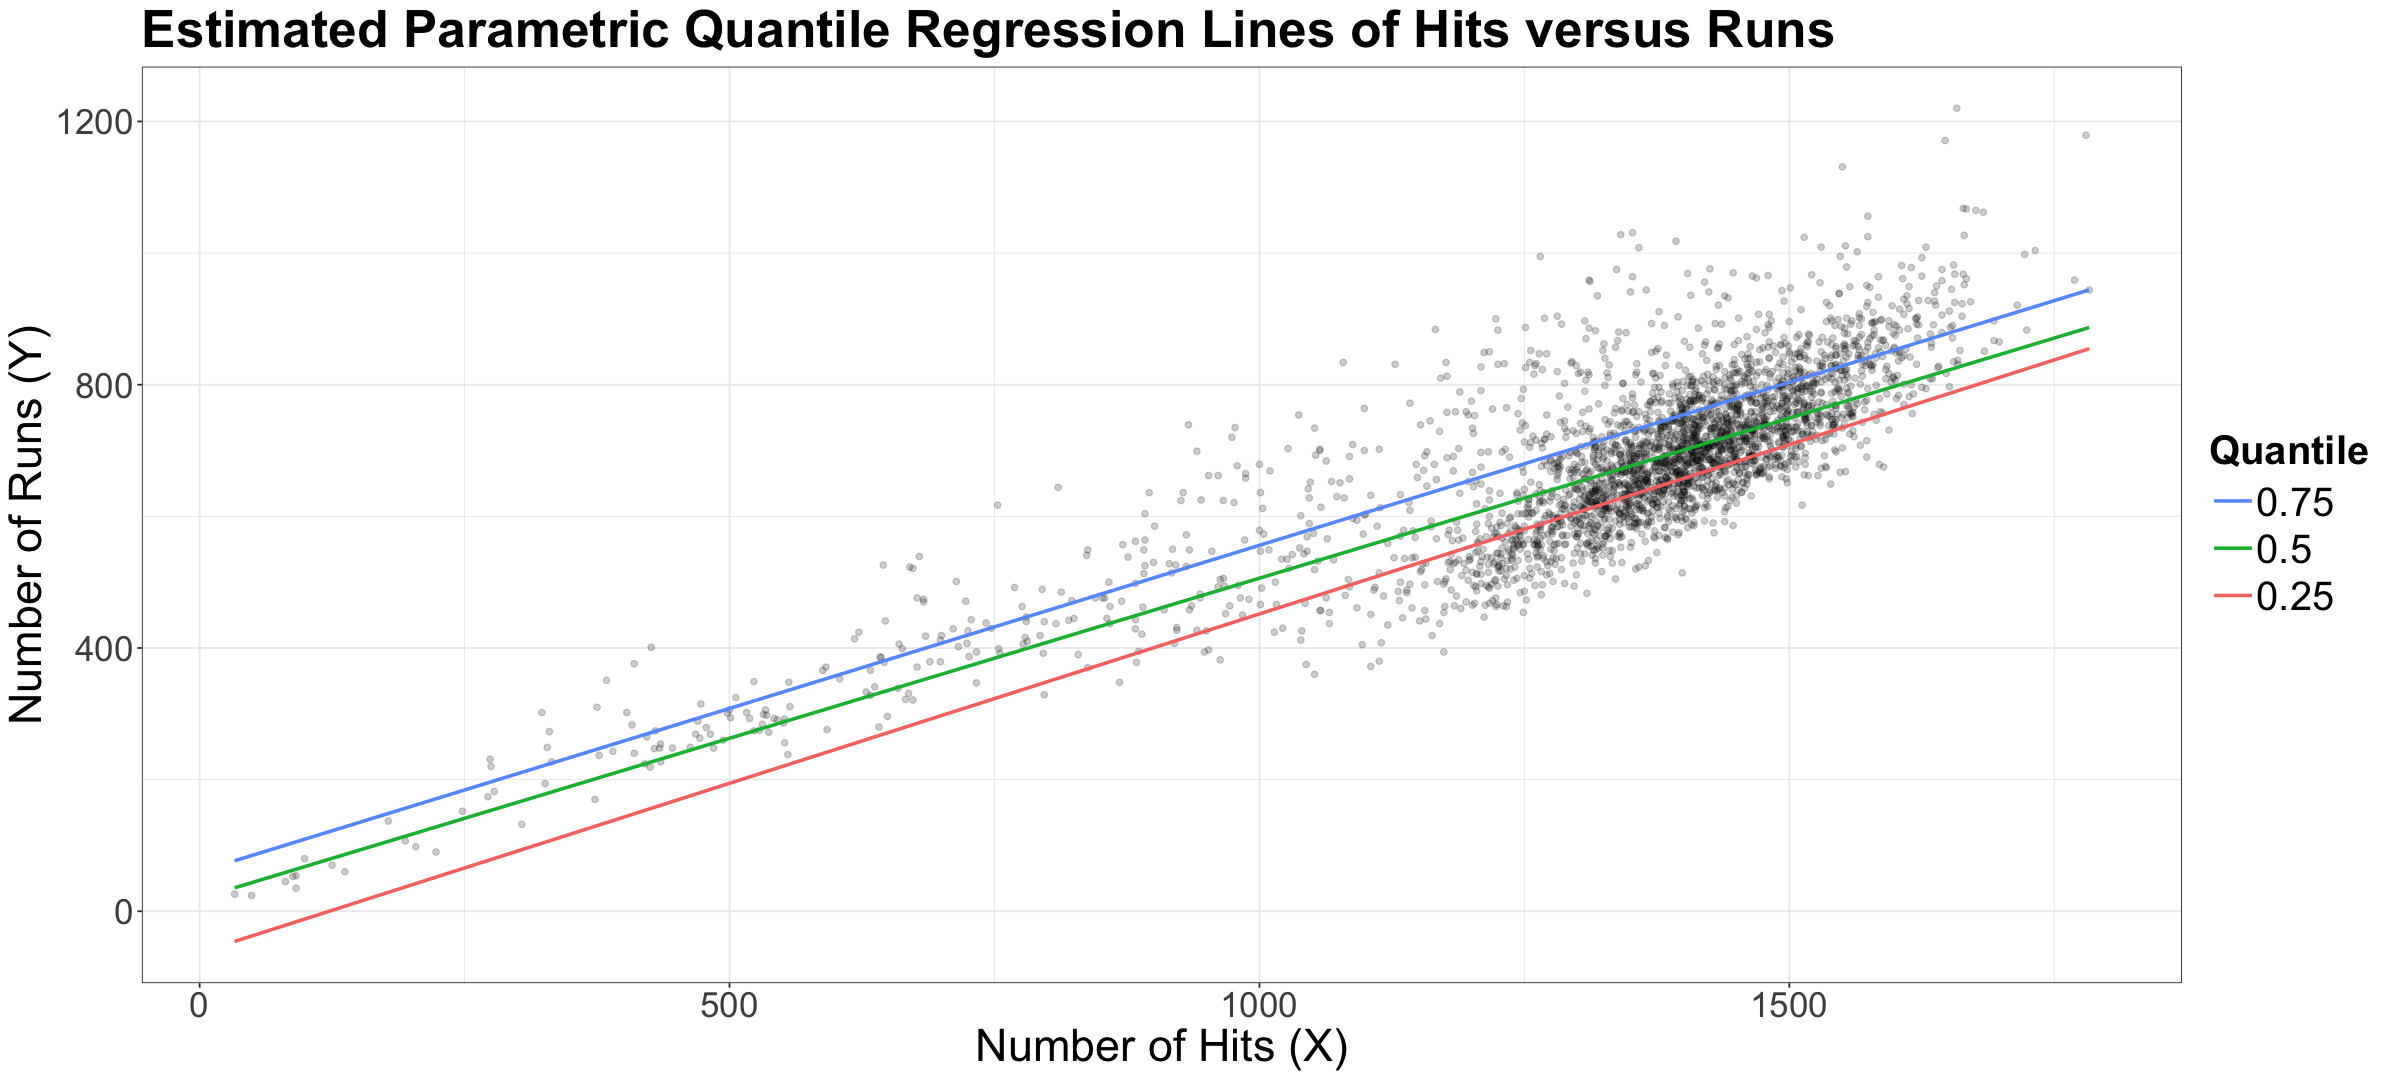

In [16]:
estimated_quantile_regression_lines <- ggplot(teams, aes(hits, runs)) +
  geom_point(alpha = 0.2, colour = "black") +
  geom_quantile(
    quantiles = c(0.25, 0.5, 0.75), aes(colour = as.factor(after_stat(quantile))),
    formula = y ~ x, linewidth = 1
  ) +
  theme_bw() +
  labs(
    x = "Number of Hits (X)",
    y = "Number of Runs (Y)"
  ) +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 24, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 24, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  guides(colour = guide_legend(title = "Quantile", reverse = TRUE)) +
  ggtitle("Estimated Parametric Quantile Regression Lines of Hits versus Runs")

estimated_quantile_regression_lines

Furthermore, from `quantreg` package, we will use the `rq()` function to fit the parametric Quantile regression at $\tau = 0.25, 0.5, 0.75$. It has a `formula` argument as the previous fitting functions along with `data`. This function also allows us to fit as many Quantile regressions as we want via `tau`.

```{important}
As in the case of OLS, modelling estimates are obtained via an optimization procedure which minimizes the fidelity function.
```

In [17]:
fit_rq_teams <- rq(formula = runs ~ hits, data = teams, tau = c(0.25, 0.5, 0.75))
summary(fit_rq_teams)


Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.25

Coefficients:
            Value     Std. Error t value   Pr(>|t|) 
(Intercept) -62.88889  16.27505   -3.86413   0.00011
hits          0.51462   0.01130   45.55183   0.00000

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.5

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 19.58352  9.23501    2.12057  0.03404
hits         0.48646  0.00682   71.28212  0.00000

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.75

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 60.33913 12.27224    4.91672  0.00000
hits         0.49565  0.00906   54.67984  0.00000

Even better, we can use `tidy()` but it will not provide the $p$-values to perform inference:

In [18]:
tidy(fit_rq_teams)

term        estimate    conf.low     conf.high  tau 
1 (Intercept) -62.8888889 -152.5987100 -9.6212616 0.25
2 hits          0.5146199    0.4789082  0.6003041 0.25
3 (Intercept)  19.5835214    8.7200812 34.1868114 0.50
4 hits          0.4864560    0.4756454  0.4952886 0.50
5 (Intercept)  60.3391304   45.7748834 80.4567238 0.75
6 hits          0.4956522    0.4814450  0.5068990 0.75

### 3.3. Inference

In terms of inference, we use the fitted model to identify the relationship between the $\tau$-quantile in our response and regressors. We will need the $j$th estimated regression parameter $\hat{\beta}_j(\tau)$ and its corresponding variability which is reflected in the **standard error** of the estimate, $\mbox{se}\left[\hat{\beta}_j (\tau) \right]$. To determine the statistical significance of $\hat{\beta}_j(\tau)$, we use the **test statistic**

$$t_j = \frac{\hat{\beta}_j(\tau)}{\mbox{se}\left[\hat{\beta}_j (\tau) \right]}$$

to test the hypotheses

```{math}
\begin{gather*}
H_0: \hat{\beta}_j(\tau) = 0 \\
H_a: \hat{\beta}_j(\tau) \neq 0.
\end{gather*}
```

A statistic like $t_j$ is referred to as a $t$-value. It has a $t$-distribution **under the null hypothesis** $H_0$ with $n - k - 1$ degrees of freedom.

We can obtain the corresponding $p$-values for each $\beta_j(\tau)$ associated to the $t$-values under the null hypothesis $H_0$. **The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$ in our sample**. Hence, small $p$-values (less than the significance level $\alpha$) indicate that the data provides evidence in favour of **association** (**or causation in the case of an experimental study!**) between the $\tau$-quantile in our response and the $j$th regressor. Similarly, given a specified $(1-\alpha) \times 100\%$ level of confidence, we can construct **confidence intervals** for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j(\tau) \pm t_{\alpha/2, n - k - 1}{\mbox{se}\left[\hat{\beta}_j (\tau) \right]},
$$

where $t_{\alpha/2, n - k - 1}$ is the upper $\alpha/2$ quantile of the $t$-distribution with $n - k - 1$ degrees of freedom.

Let us recall our inquiry (1):

> 1. Previous research has shown you that a large number of runs is associated with a large number of hits. Having said that, **for those teams at the upper 75% threshold in runs**, is this association significant? If so, by how much?

This inferential question corresponds to the estimated $0.75$-Quantile regression:

In [19]:
summary(fit_rq_teams)[3]

[[1]]

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.75

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 60.33913 12.27224    4.91672  0.00000
hits         0.49565  0.00906   54.67984  0.00000


Our sample gives us evidence to reject $H_0$ ($p\text{-value} < .001$). So `hits` is statistically associated to the $0.75$-quantile of `runs`.

### 3.4. Coefficient Intepretation

We can quantify the statistical association of `hits` and the $0.75$-quantile of `runs` via the corresponding $\hat{\beta}_1(0.75)$.

In [20]:
tidy(fit_rq_teams) %>%
  filter(tau == 0.75) %>% 
  mutate_if(is.numeric, round, 2)

term        estimate conf.low conf.high tau 
1 (Intercept) 60.34    45.77    80.46     0.75
2 hits         0.50     0.48     0.51     0.75

The interpretation is: 

> For each one hit increase, the $0.75$-quantile of runs will increase by 0.5.

```{important}
In general, coefficient interpretation works as in OLS (for continuous and categorical regressors). Nevertheless, this interpretation will be targeted towards the $\tau$-quantile of the response.
```

### 3.5. Predictions

Now, let us check our inquiry (2):

> 2. **For any given team that scores 1000 hits in a future tournament**, how many runs can this team score with a 50% chance (centred around this future tournament's median runs)?

We can obtain this prediction via our $0.25$ and $0.75$-Quantile regressions with `predict()`.

In [21]:
round(predict(fit_rq_teams, newdata = data.frame(hits = 1000)), 0)

tau= 0.25 tau= 0.50 tau= 0.75
1 452       506       556

Thus, our predictive inquiry can be answered as: **"for any given team that scores 1000 hits in a future tournament, it is estimated to have a 50% ($0.75 - 0.25 \times 100\%$) chance to have between 452 and 556 runs."**

```{important}
**This is a probabilistic prediction!**
```

Note we could also say that this team: 

- has a 25% ($1 - 0.75 \times 100\%$) chance of achieving **over** 556 runs,
- has a 25% ($0.25 \times 100\%$) chance of getting **less** than 450 runs,
- and would typically get 506 runs (**median**).

amongst other things.

## 4. Non-Parametric Quantile Regression

The predictive inquiry (2) can also be dealt with via non-parametric Quantile regression. This class of Quantile regression implicates **no distributional assumptions and no model function specification**. The core idea is to allow the model to capture the local behaviour of the data (i.e., **capturing its local structure**).

### 4.1. General Modelling Framework

Now, the struggle is choosing **how local** our model should be. In other words, what is the neighbourhood of a point $x$? A parameter will control this. We will call it `lambda`, a **penalization** parameter:

- A **small neighbourhood** (i.e., a small `lambda`) will provide a better approximation, but with too much variability - the model will not be smooth.
- A **too-large neighbourhood** (i.e., a big `lambda`), we lose local information favouring smoothness, going towards a global model.

### 4.2. Estimation

In `R`, non-parametric Quantile regression is performed using the function `rqss()` from library `quantreg`. It also works somewhat similarly to what we are used to with the `lm()` and `glm()` functions.

However, in `rqss()` each regressor must be introduced in the formula using the `qss()` function (as **additive non-parametric terms**). For example, `qss(x, lambda = 3)`.

The syntax would be:

```
rqss(y ~ qss(x, lambda = 10), tau = 0.5, data = my_data)
```

We use `rqss()` to run a non-parametric Quantile regression with `runs` as the response and `hits` as the regressor. We use a `tau = 0.25` and `tau = 0.75`. Note `rqss()` does not allow multiple values for `tau`. Therefore, we fit a model per `tau` value. Here, we try a `lambda = 100`.

In [22]:
rqss_model_0.25_lambda_100 <- rqss(runs ~ qss(hits, lambda = 100), tau = 0.25, data = teams)
summary(rqss_model_0.25_lambda_100)

Formula:
runs ~ qss(hits, lambda = 100)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   14.841      9.334    1.59    0.112

Approximate significance of qss terms:
     EDF Lambda Penalty F value Pr(>F)    
hits  17    100   3.162    3255 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Quantile Fidelity at tau = 0.25  is      62180.5
  Effective Degrees of Freedom = 21        Sample Size = 3015

In [23]:
rqss_model_0.75_lambda_100 <- rqss(runs ~ qss(hits, lambda = 100), tau = 0.75, data = teams)
summary(rqss_model_0.75_lambda_100)

Formula:
runs ~ qss(hits, lambda = 100)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    12.93      10.63   1.217    0.224

Approximate significance of qss terms:
     EDF Lambda Penalty F value Pr(>F)    
hits  22    100   9.176   19099 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Quantile Fidelity at tau = 0.75  is      75264.6
  Effective Degrees of Freedom = 24        Sample Size = 3015

Then, we plot the two model functions on the data plot. This is basically our **prediction band** (which can also apply to our parametric models!).

In [24]:
grid_teams_0.25_lambda_100 <- teams %>% 
  data_grid(hits) %>% 
  add_predictions(rqss_model_0.25_lambda_100)

grid_teams_0.75_lambda_100 <- teams %>% 
  data_grid(hits) %>% 
  add_predictions(rqss_model_0.75_lambda_100)

non_param_teams_scatterplot_lambda_100 <- teams_scatterplot +
  geom_line(aes(hits, pred, colour = "0.75"), data = grid_teams_0.75_lambda_100, linewidth = 1) +
  geom_line(aes(hits, pred, colour = "0.25"), data = grid_teams_0.25_lambda_100, linewidth = 1) +
  theme(
    plot.title = element_text(size = 31),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 24, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 24, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  scale_color_manual(name = "Quantile", values = c("0.75" = "red", "0.25" = "blue")) +
  guides(colour = guide_legend(reverse = TRUE)) +
  ggtitle(bquote("Estimated Non-Parametric Quantile Regression Lines of Hits versus Runs with" ~ lambda ~ "= 100"))

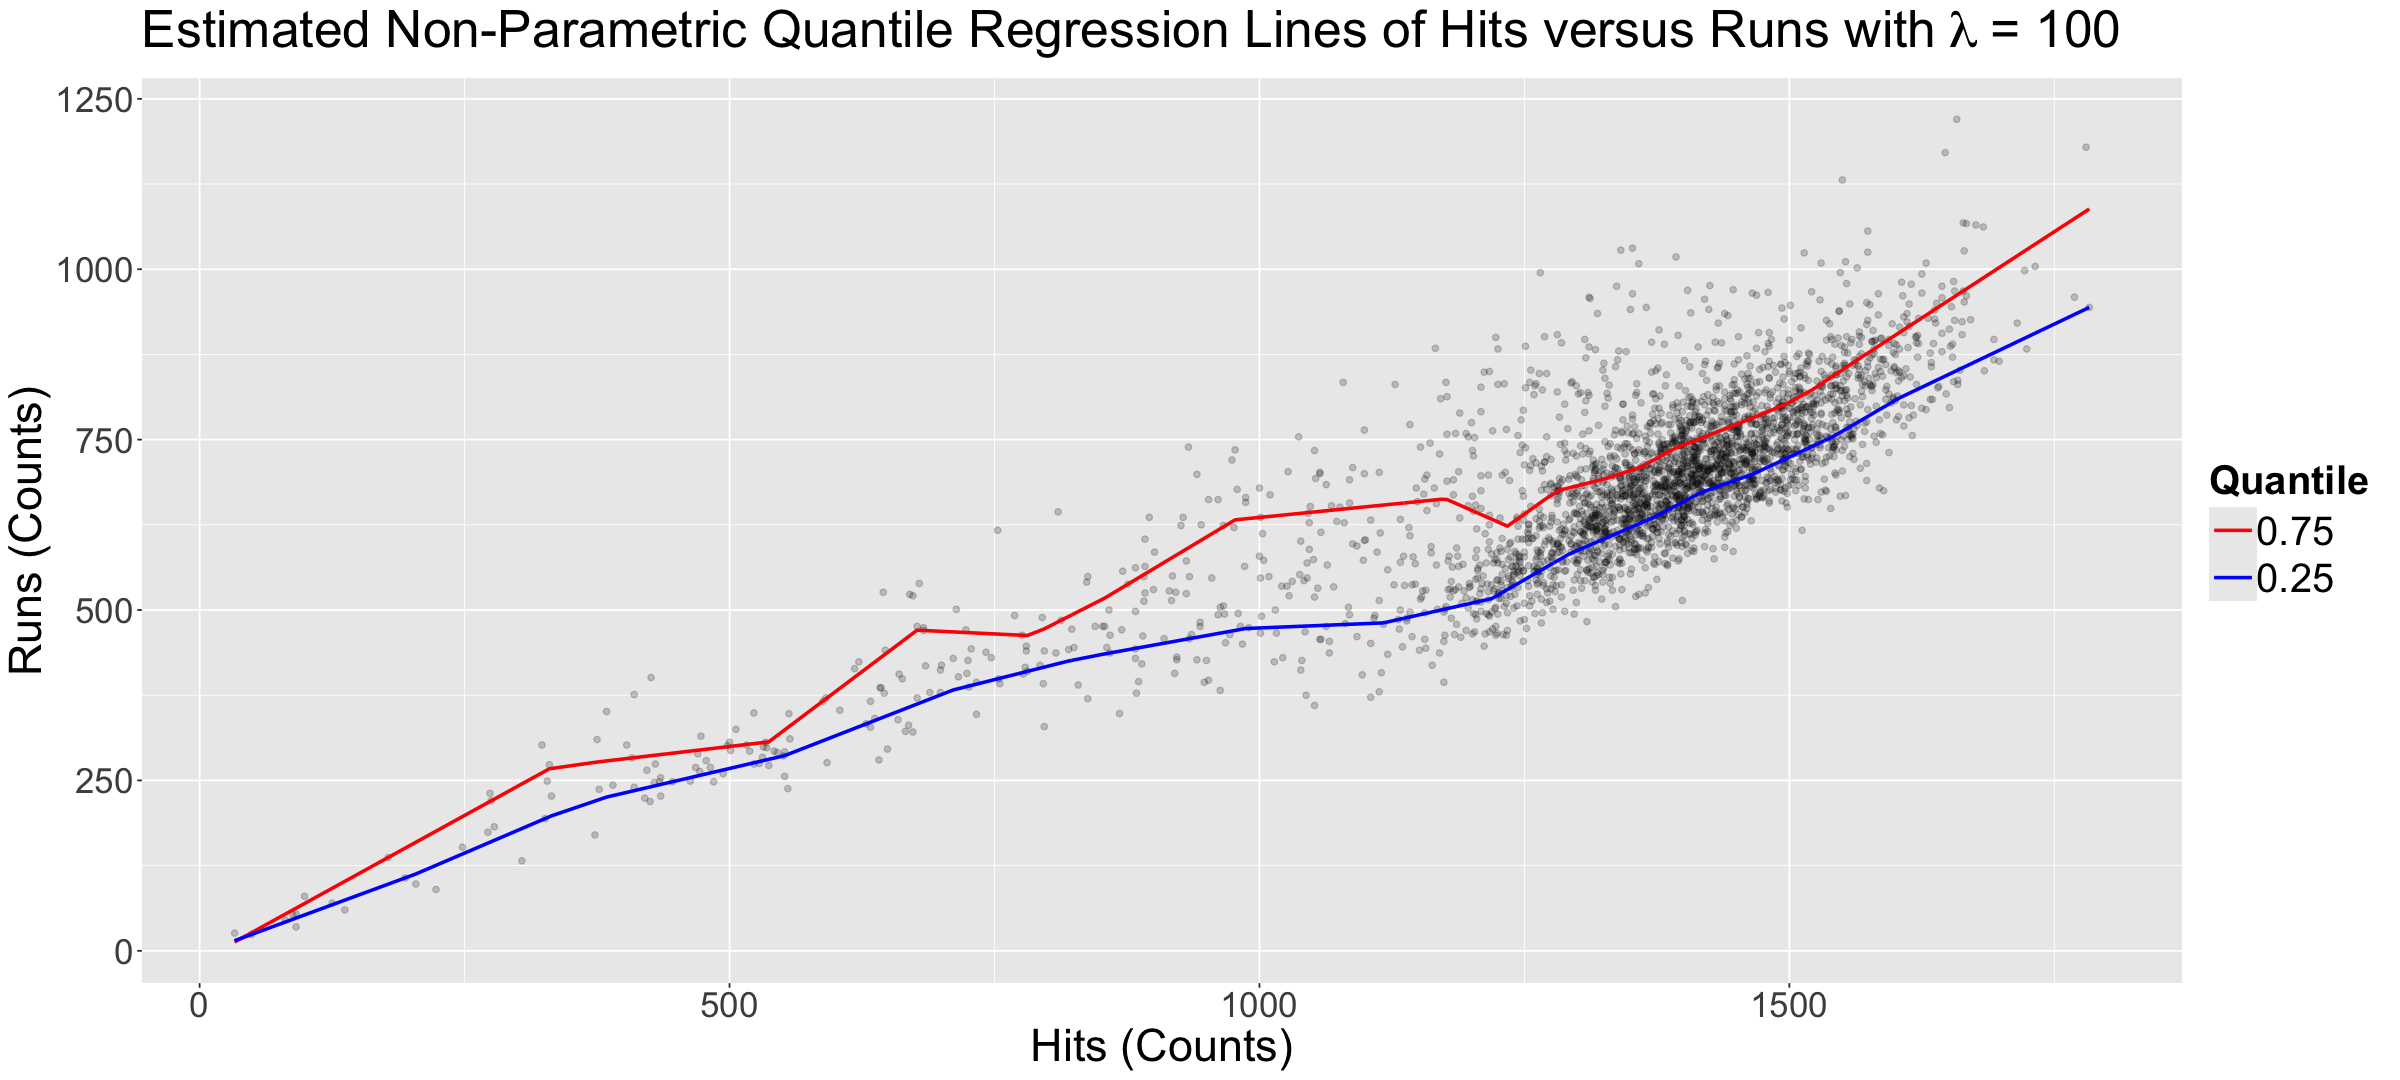

In [25]:
non_param_teams_scatterplot_lambda_100

**What if we use `lambda = 15`?** Our estimated functions **will not be that smooth** anymore, there will be more variability on the prediction.

In [26]:
rqss_model_0.25_lambda_15 <- rqss(runs ~ qss(hits, lambda = 15), tau = 0.25, data = teams)
summary(rqss_model_0.25_lambda_15)

Formula:
runs ~ qss(hits, lambda = 15)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    17.45      13.90   1.256    0.209

Approximate significance of qss terms:
     EDF Lambda Penalty F value Pr(>F)    
hits  48     15    31.4    1121 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Quantile Fidelity at tau = 0.25  is      61780.8
  Effective Degrees of Freedom = 53        Sample Size = 3015

In [27]:
rqss_model_0.75_lambda_15 <- rqss(runs ~ qss(hits, lambda = 15), tau = 0.75, data = teams)
summary(rqss_model_0.75_lambda_15)

Formula:
runs ~ qss(hits, lambda = 15)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)     26.0       13.8   1.884   0.0597 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of qss terms:
     EDF Lambda Penalty F value Pr(>F)    
hits  60     15    87.4    4732 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Quantile Fidelity at tau = 0.75  is      74017.3
  Effective Degrees of Freedom = 61        Sample Size = 3015

In [28]:
grid_teams_0.25_lambda_15 <- teams %>% 
  data_grid(hits) %>% 
  add_predictions(rqss_model_0.25_lambda_15)

grid_teams_0.75_lambda_15 <- teams %>% 
  data_grid(hits) %>% 
  add_predictions(rqss_model_0.75_lambda_15)

non_param_teams_scatterplot_lambda_15 <- teams_scatterplot +
  geom_line(aes(hits, pred, colour = "0.75"), data = grid_teams_0.75_lambda_15, linewidth = 1) +
  geom_line(aes(hits, pred, colour = "0.25"), data = grid_teams_0.25_lambda_15, linewidth = 1) +
  theme(
    plot.title = element_text(size = 31),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 24, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 24, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  scale_color_manual(name = "Quantile", values = c("0.75" = "red", "0.25" = "blue")) +
  guides(colour = guide_legend(reverse = TRUE)) +
  ggtitle(bquote("Estimated Non-Parametric Quantile Regression Lines of Hits versus Runs with" ~ lambda ~ "= 15"))

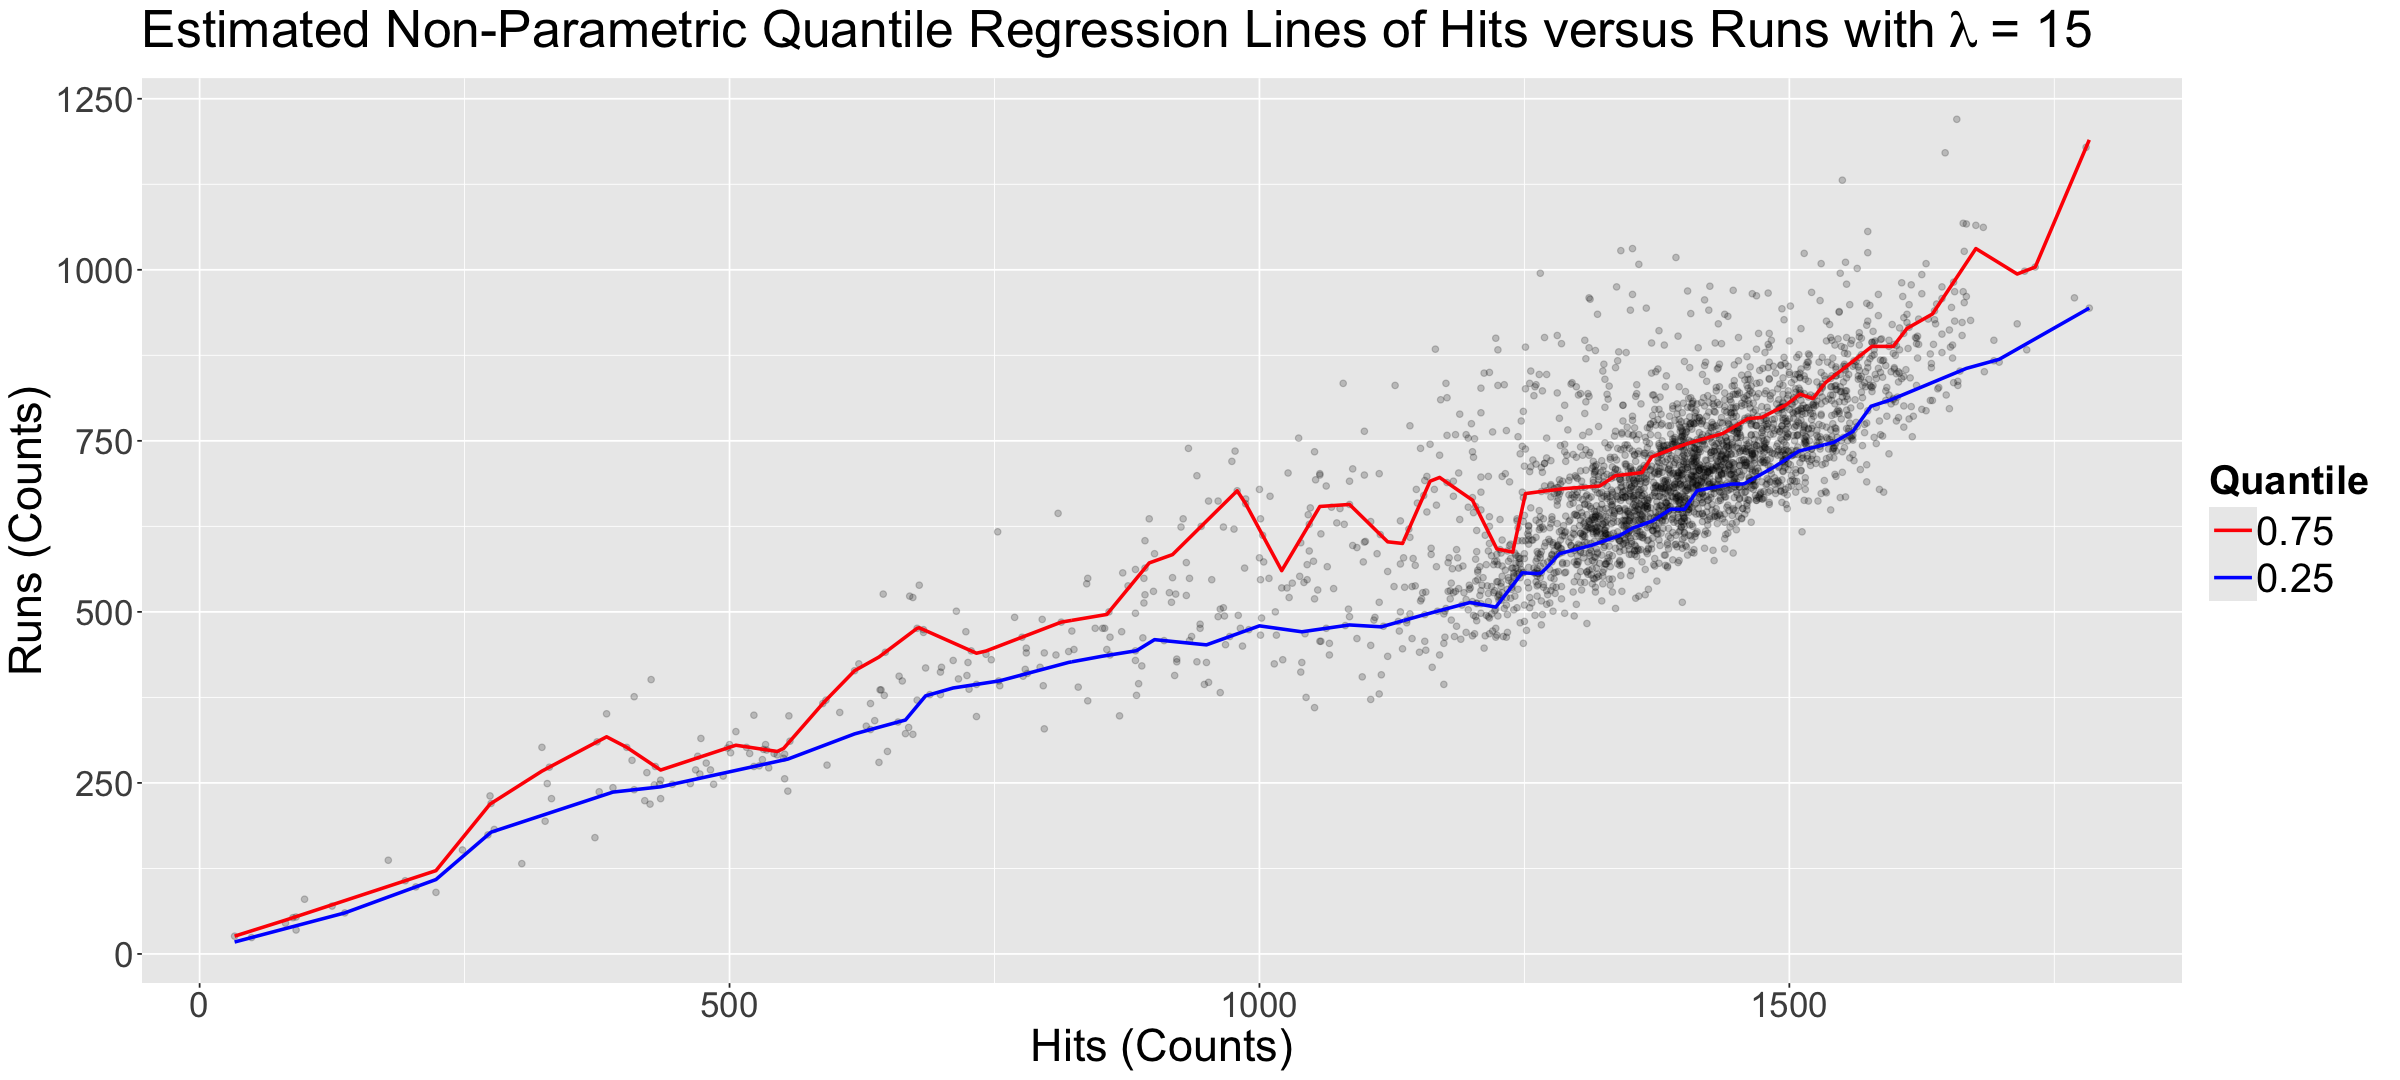

In [29]:
non_param_teams_scatterplot_lambda_15

As a sanity check, let us calculate the **proportion of points below** these estimated regression functions with $\lambda = 15$.

In [30]:
teams %>%
  mutate(pred = predict(rqss_model_0.25_lambda_15, newdata = teams)[, 1]) %>%
  summarise(prop_below_curve = mean(runs < pred))

prop_below_curve
1 0.2504146

In [31]:
teams %>%
  mutate(pred = predict(rqss_model_0.75_lambda_15, newdata = teams)[, 1]) %>%
  summarise(prop_below_curve = mean(runs < pred))

prop_below_curve
1 0.7492537

### 4.3. Prediction

Suppose that we go ahead with the non-parametric models with $\lambda = 15$, then we obtain the corresponding **probabilistic interval**:

In [32]:
as.vector(round(predict(rqss_model_0.25_lambda_15, newdata = data.frame(hits = 1000)), 0))

[1] 480

In [33]:
as.vector(round(predict(rqss_model_0.75_lambda_15, newdata = data.frame(hits = 1000)), 0))

[1] 621

Thus, our predictive inquiry can be answered as: 

> For any given team that scores 1000 hits in a future tournament, it is estimated to have a 50% ($0.75 - 0.25 \times 100\%$) chance to have between 480 and 621 runs.

```{important}
Having said all this regarding parametric and non-parametric Quantile regressions, you might wonder: **when to use what?**

In general, non-parametric Quantile regression might be adequate for predictive inquiries via non-linear training data. On the other hand, untangling an interpretable numeric association (or causation!) between our quantile response and some regressor would imply parametric Quantile regression.
```

## (Optional) 5. Quantile Regression and Discrete Data

We previously stated that to use Quantile regression with a count-type response, we would need to make extra adjustments if the response is **much less scattered**. Hence, let us introduce a dataset with this condition.

### 5.1. The Crabs Dataset

The data frame `crabs` ([Brockmann, 1996](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1439-0310.1996.tb01099.x)) is a dataset detailing the **counts of satellite male crabs** residing around a female crab nest. The code below renames the original response's name, `satell`, to `n_males`. We will work with the continuous carapace `width` as a regressor.

``` {figure} ../img/crab.png
:height: 350px
Hello! I'm the crab, again!
```

```{admonition} The Crabs Dataset
The data frame `crabs` contains 173 observations on horseshoe crabs (Limulus polyphemus). The response is the count of male crabs (`n_males`) around a female breeding nest. It is subject to four explanatory variables: `color` of the prosoma with four levels (nominal factor-type), the condition of the posterior `spine` with three levels (nominal factor-type), the continuous variables carapace `width` (mm), and `weight` (g).
```

In [34]:
data(crabs)
crabs_raw <- crabs %>%
  rename(n_males = satell) %>%
  dplyr::select(width, n_males)
crabs_raw

width n_males
1   28.3  8      
2   22.5  0      
3   26.0  9      
⋮   ⋮     ⋮      
171 28.0  0      
172 27.0  0      
173 24.5  0

### 5.2. Initial Model Estimation

Next, let us fit a sequence of quantiles $\tau$ to the data, then add the fitted values to the dataset. This is what `geom_quantile()` does behind the scenes.

In [35]:
# Copying the raw data.
crabs <- crabs_raw

# Specifying the desired quantiles.
tau <- seq(0.2, 0.8, 0.2)

# Fitting the parametric model for the desired quantiles.
fit_rq_crabs <- rq(n_males ~ width, data = crabs, tau = tau)

pred <- fit_rq_crabs$fitted.values
colnames(pred) <- round(fit_rq_crabs$tau, 2)

# Creating a tibble with the fitted values for each quantile model.
pred <- as_tibble(pred, colnames = fit_rq_crabs$tau) %>%
  mutate(width = crabs$width) %>%
  gather(key = tau, value = pred, -width) %>%
  mutate(tau = as.double(tau))

# Joining the pred tibble to the crabs tibble.
crabs <- crabs_raw %>%
  left_join(pred, relationship = "many-to-many")

crabs

Joining with `by = join_by(width)`


width n_males tau pred    
1    28.3  8       0.2 0       
2    28.3  8       0.2 0       
3    28.3  8       0.2 0       
⋮    ⋮     ⋮       ⋮   ⋮       
2690 24.5  0       0.8 4.604651
2691 24.5  0       0.8 4.604651
2692 24.5  0       0.8 4.604651

Now, let us check the `summary()` of `fit_rq_crabs`. 

**Note that the estimated $0.2$-Quantile regression is providing estimates at zero!**

In [36]:
summary(fit_rq_crabs)


Call: rq(formula = n_males ~ width, tau = tau, data = crabs)

tau: [1] 0.2

Coefficients:
            coefficients lower bd upper bd
(Intercept)  0.00000     -9.19111  0.00000
width        0.00000      0.00000  0.35017

Call: rq(formula = n_males ~ width, tau = tau, data = crabs)

tau: [1] 0.4

Coefficients:
            coefficients lower bd  upper bd 
(Intercept) -11.00000    -15.15960  -9.14239
width         0.47619      0.40141   0.64616

Call: rq(formula = n_males ~ width, tau = tau, data = crabs)

tau: [1] 0.6

Coefficients:
            coefficients lower bd  upper bd 
(Intercept) -11.76000    -18.48730  -6.69196
width         0.56000      0.39454   0.84914

Call: rq(formula = n_males ~ width, tau = tau, data = crabs)

tau: [1] 0.8

Coefficients:
            coefficients lower bd  upper bd 
(Intercept)  -6.79070    -23.73913  -0.93342
width         0.46512      0.25590   1.00503

Finally, let us plot the data and our fitted models (**one model for each quantile**).

In [37]:
p_crabs <- ggplot(crabs, aes(width, n_males)) +
  geom_point(alpha = 0.8) +
  theme_bw() +
  geom_line(aes(x = width, y = pred, colour = as.factor(tau)), linewidth = 1) +
  labs(
    x = "Carapace Width (mm)",
    y = "Number of Nearby Males"
  ) +
  theme(
    plot.title = element_text(size = 28, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 24, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 24, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  guides(colour = guide_legend(title = "Quantile", reverse = TRUE)) +
  ggtitle("Estimated Parametric Quantile Regression Lines of Carapace Width versus Number of Nearby Males")

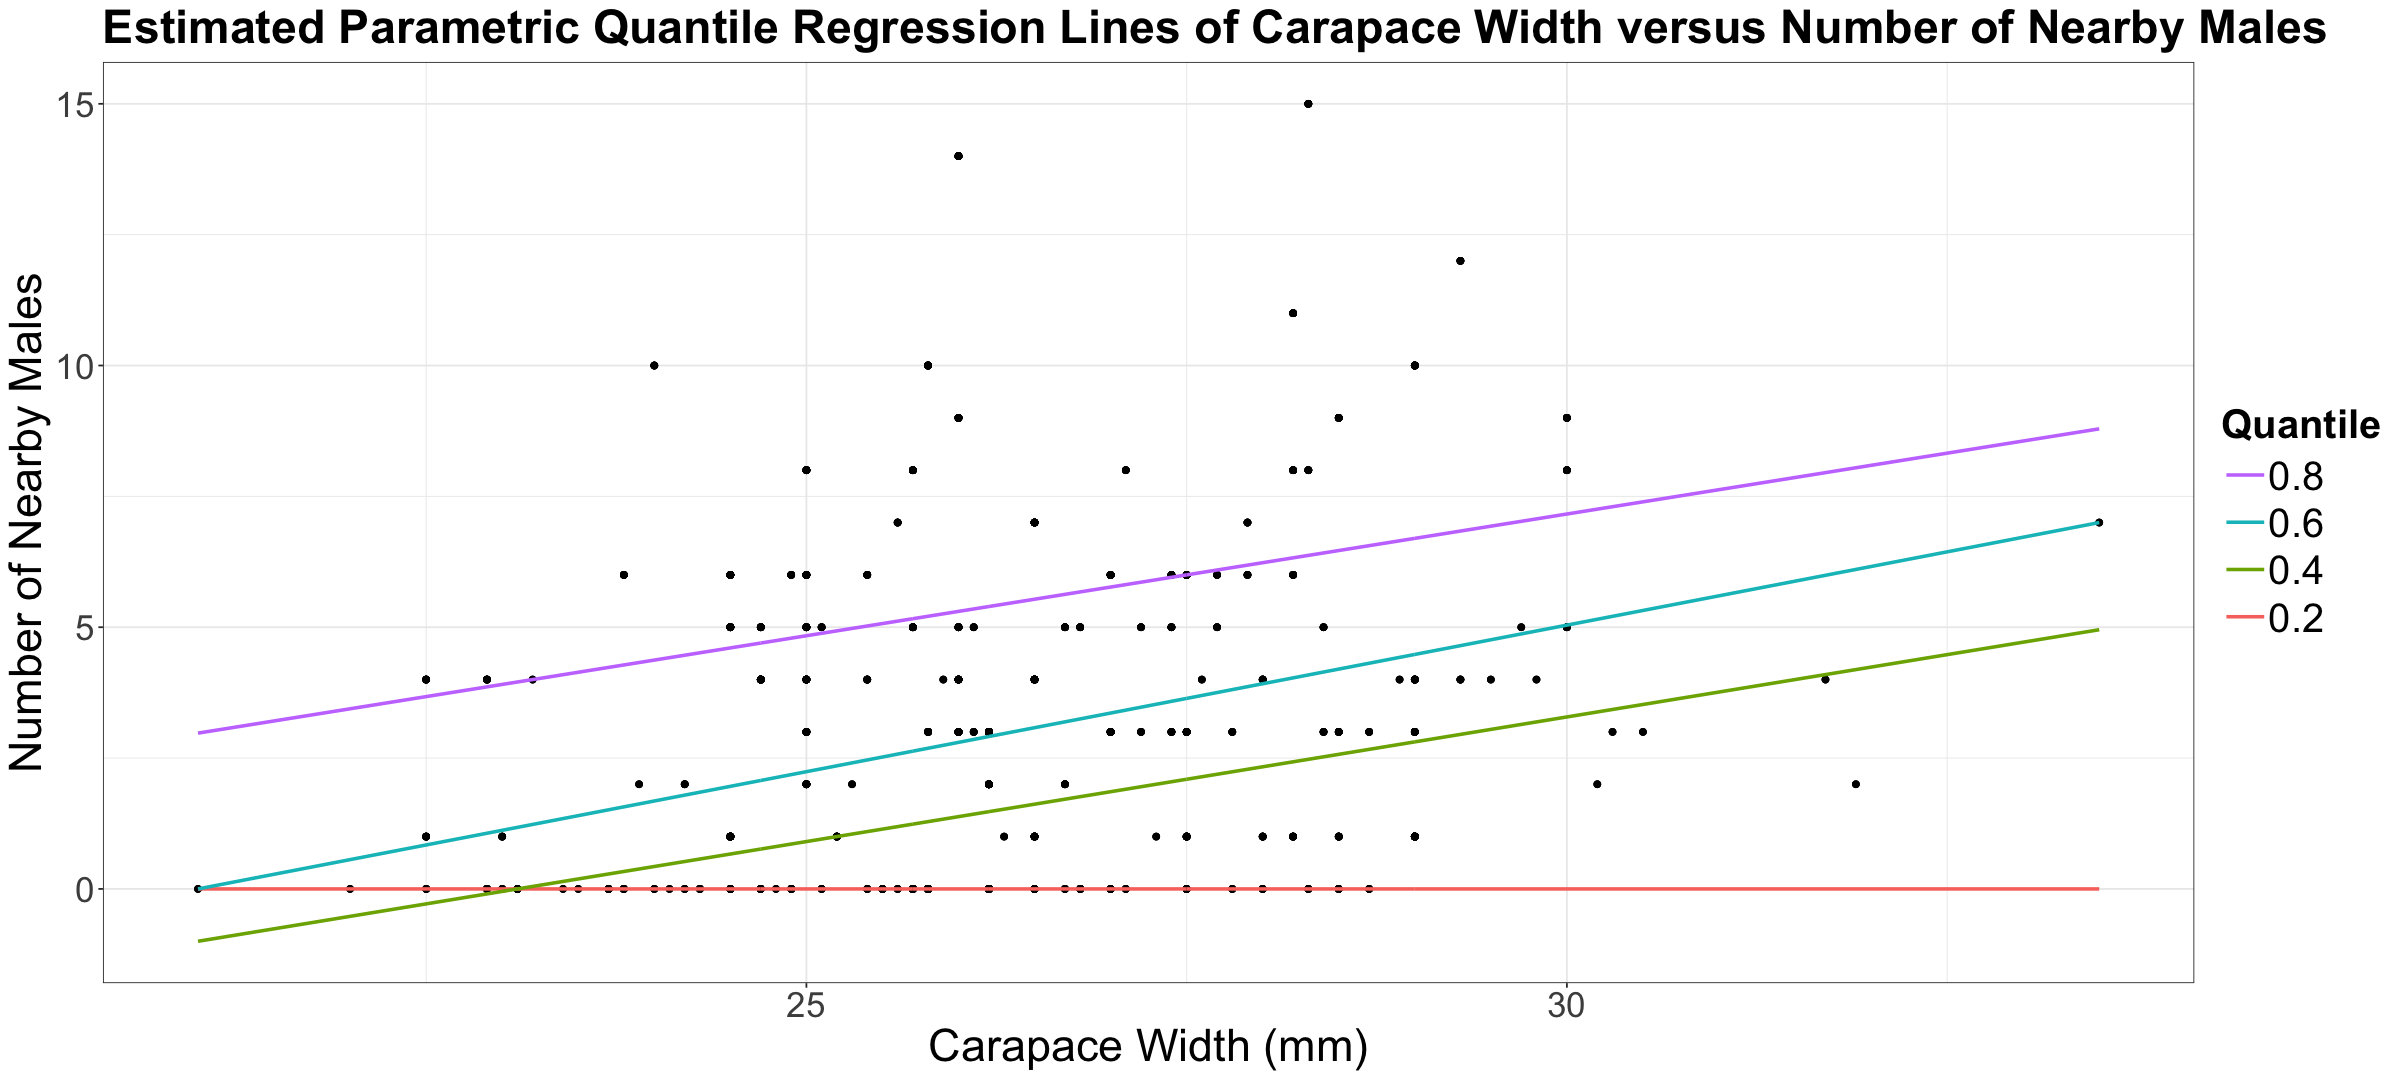

In [38]:
p_crabs 

There are **two important things** to observe here:

1. If we use lower quantiles, say less than 0.2, **the quantile regression is fitting a horizontal line at zero**.
2. Observe the model fitted for $\tau = 0.4$ and $\tau = 0.2$. For low values of the carapace width, they cross paths.

Furthermore, note that around 36% in `crabs_raw` of the response `n_males` is 0. **This is going to have an critical impact on the lower quantiles.**

In [39]:
round(nrow(crabs_raw %>% filter(n_males == 0))/ nrow(crabs_raw), 2)

[1] 0.36

Let us estimate the **standard error** of our parameters for $\tau\in\{0.05, 0.1, 0.15, 0.2\}$.

In [40]:
summary(rq(n_males ~ width, data = crabs_raw, tau = c(0.05, 0.1, 0.15, 0.2)))


Call: rq(formula = n_males ~ width, tau = c(0.05, 0.1, 0.15, 0.2), 
    data = crabs_raw)

tau: [1] 0.05

Coefficients:
            coefficients lower bd upper bd
(Intercept) 0            0        0       
width       0            0        0       

Call: rq(formula = n_males ~ width, tau = c(0.05, 0.1, 0.15, 0.2), 
    data = crabs_raw)

tau: [1] 0.1

Coefficients:
            coefficients lower bd upper bd
(Intercept) 0            0        0       
width       0            0        0       

Call: rq(formula = n_males ~ width, tau = c(0.05, 0.1, 0.15, 0.2), 
    data = crabs_raw)

tau: [1] 0.15

Coefficients:
            coefficients lower bd upper bd
(Intercept)  0.00000     -7.92981  0.00000
width        0.00000      0.00000  0.30989

Call: rq(formula = n_males ~ width, tau = c(0.05, 0.1, 0.15, 0.2), 
    data = crabs_raw)

tau: [1] 0.2

Coefficients:
            coefficients lower bd upper bd
(Intercept)  0.00000     -9.19111  0.00000
width        0.00000      0.00000  0.35017

But we have standard errors equal to zero in our lower quantiles! **This does not make any sense from the inferential point of view.**

In turns out that Quantile regression relies on the **asymptotical normality of the statistics** and this is not achieved when we have a discrete $Y$, such as `n_males`. Therefore, in those cases, the inferential quantities are not reliable. 

### 5.3. Model Estimation via `dither()`

For count data, you can use the `dither()` function from package `quantreg` package to introduce some **random perturbation** (i.e., inducing random noise). The argument `type = "right"` specifies we only want strictly positive perturbations (since we are dealing with counts).

In [41]:
set.seed(123) # To ensure reproducibility in our random perturbation.
tau <-  c(0.05, 0.1, 0.15, 0.2)
fit_rq_crabs_dither <- rq(dither(n_males, type = "right", value = 1) ~ width, data = crabs_raw, tau = tau)
summary(fit_rq_crabs_dither)


Call: rq(formula = dither(n_males, type = "right", value = 1) ~ width, 
    tau = tau, data = crabs_raw)

tau: [1] 0.05

Coefficients:
            coefficients lower bd upper bd
(Intercept) -2.86010     -7.28338 -1.18756
width        0.12127      0.03290  0.28750

Call: rq(formula = dither(n_males, type = "right", value = 1) ~ width, 
    tau = tau, data = crabs_raw)

tau: [1] 0.1

Coefficients:
            coefficients lower bd upper bd
(Intercept) -3.67607     -5.95325 -1.75594
width        0.15884      0.08239  0.24640

Call: rq(formula = dither(n_males, type = "right", value = 1) ~ width, 
    tau = tau, data = crabs_raw)

tau: [1] 0.15

Coefficients:
            coefficients lower bd upper bd
(Intercept) -4.14444     -8.15272 -1.99403
width        0.17998      0.09449  0.33215

Call: rq(formula = dither(n_males, type = "right", value = 1) ~ width, 
    tau = tau, data = crabs_raw)

tau: [1] 0.2

Coefficients:
            coefficients lower bd upper bd
(Intercept) -5.37683     -7.

Then, we plot our in-sample predictions.

In [42]:
pred <- fit_rq_crabs_dither$fitted.values
colnames(pred) <- round(fit_rq_crabs_dither$tau, 2)

# Creating a tibble with the fitted values for each quantile model.
pred <- as_tibble(pred, colnames = fit_rq_crabs_dither$tau) %>%
  mutate(width = crabs_raw$width) %>%
  gather(key = tau, value = pred, -width) %>%
  mutate(tau = as.double(tau))

# Joining the pred tibble to the crab tibble.
crabs_dither <-
  crabs_raw %>%
  left_join(pred, relationship = "many-to-many")

p_crabs_dither <- ggplot(crabs_dither, aes(width, n_males)) +
  geom_point(alpha = 0.8) +
  geom_line(aes(x = width, y = pred, colour = as.factor(tau)), linewidth = 1) +
  theme_bw() +
  labs(
    x = "Carapace Width (mm)",
    y = "Number of Nearby Males"
  ) +
  theme(
    plot.title = element_text(size = 28, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 24, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 24, face = "bold"),
    legend.key.size = unit(1, "cm")
  ) +
  guides(colour = guide_legend(title = "Quantile", reverse = TRUE)) +
  ggtitle("Estimated Parametric Quantile Regression Lines of Carapace Width versus Number of Nearby Males")

Joining with `by = join_by(width)`


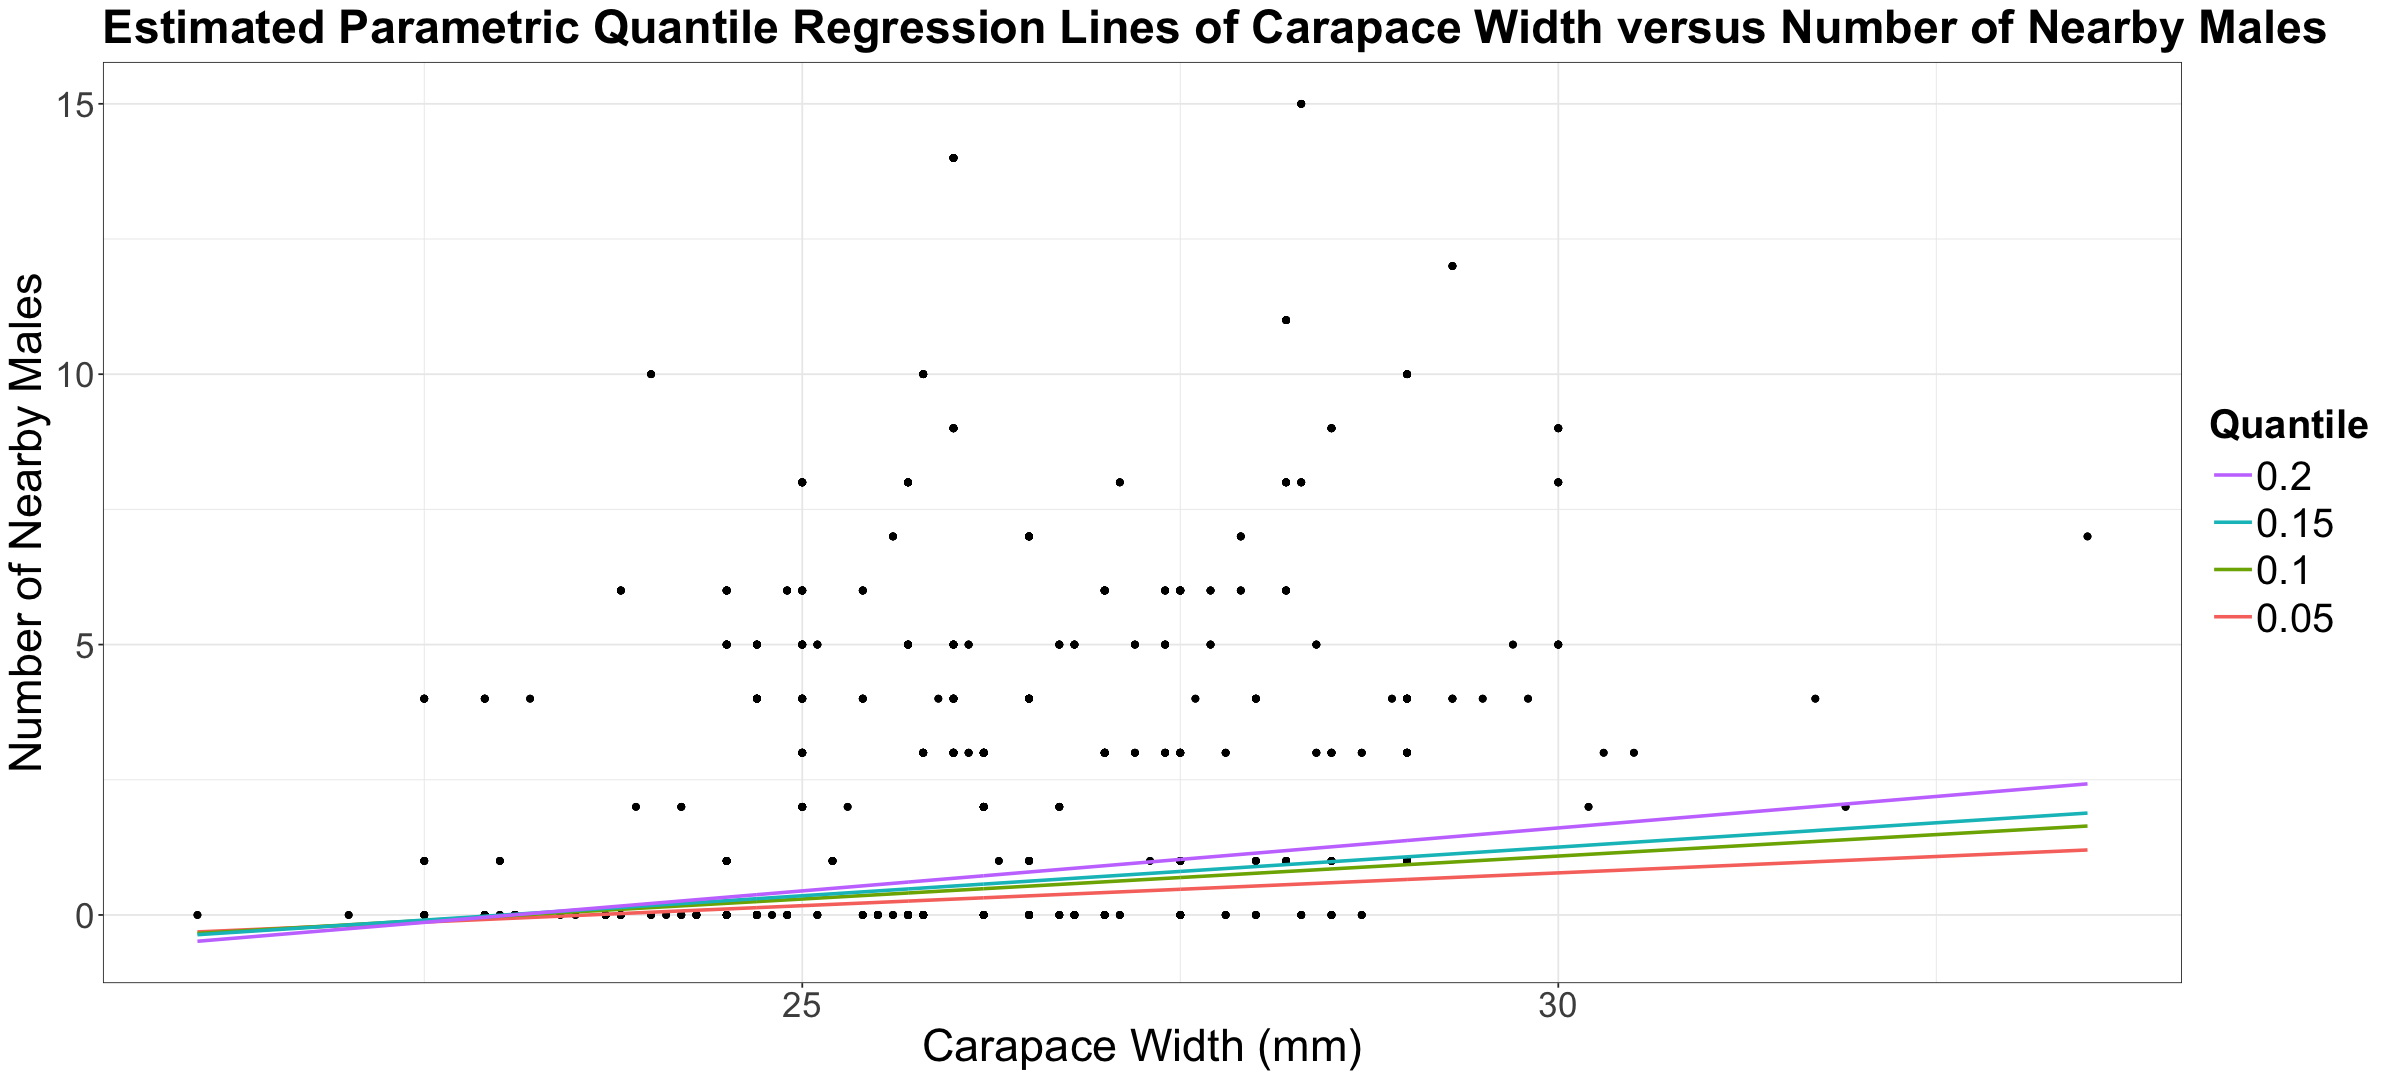

In [43]:
p_crabs_dither 

We now have distinct lines for the low quantiles.

```{admonition} Why was not this a big problem with the previous baseball-related dataset?
Because, given the size of the counts of around 400 to 800 in dataset `teams`, the points "behave similarly" to continuous data. However, we still could (and should!) use the `dither()` function in the `teams` model, but the results should be fairly similar (compare the output below with the one you obtained at the beginning with `teams`).
```

Let us refit our parametric Quantile regressions with `tau = c(0.25, 0.5, 0.75)` in dataset `teams` using `dither()` .

In [44]:
set.seed(123)
fit_rq_teams_dither_final <- rq(dither(runs, type = "right", value = 1) ~ hits, data = teams, tau = c(0.25, 0.5, 0.75))
summary(fit_rq_teams_dither_final)


Call: rq(formula = dither(runs, type = "right", value = 1) ~ hits, 
    tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.25

Coefficients:
            Value     Std. Error t value   Pr(>|t|) 
(Intercept) -63.80693  16.03006   -3.98046   0.00007
hits          0.51561   0.01112   46.34972   0.00000

Call: rq(formula = dither(runs, type = "right", value = 1) ~ hits, 
    tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.5

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 19.77599  9.41214    2.10112  0.03571
hits         0.48670  0.00695   70.03725  0.00000

Call: rq(formula = dither(runs, type = "right", value = 1) ~ hits, 
    tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.75

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 60.73963 12.33464    4.92431  0.00000
hits         0.49586  0.00910   54.49468  0.00000

Then, if we compare them to our initial models, we can see that our modelling summaries are similar.

In [45]:
summary(fit_rq_teams)


Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.25

Coefficients:
            Value     Std. Error t value   Pr(>|t|) 
(Intercept) -62.88889  16.27505   -3.86413   0.00011
hits          0.51462   0.01130   45.55183   0.00000

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.5

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 19.58352  9.23501    2.12057  0.03404
hits         0.48646  0.00682   71.28212  0.00000

Call: rq(formula = runs ~ hits, tau = c(0.25, 0.5, 0.75), data = teams)

tau: [1] 0.75

Coefficients:
            Value    Std. Error t value  Pr(>|t|)
(Intercept) 60.33913 12.27224    4.91672  0.00000
hits         0.49565  0.00906   54.67984  0.00000

## 6. Wrapping Up

- We can extend the regression paradigm beyond the conditioned response mean.
- We could assess association (or causation under a proper experimental framework!) via different response statistics such as quantiles to a set of regressors.
- Quantile regression can be non-parametric (more suitable for predictions) or parametric (to allow for coefficient interpretation).